<a href="https://colab.research.google.com/github/ozturkc/fuzzy-pso-portfolio-optimization/blob/main/Fuzzy_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Change working directory to a desired folder in your Drive
#    (Ensure that this folder path actually exists or create it beforehand)
os.chdir('/content/drive/MyDrive/Fuzzy-PSO')

# 3. Verify current directory
print("Current working directory:", os.getcwd())

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/Fuzzy-PSO


In [ ]:
# GPU kullanımı için ayar: GPU varsa kullan, yoksa CPU kullan
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Kullanılan cihaz:", device)

Kullanılan cihaz: cuda


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 16 12:14:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   44C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Gerekli kütüphanelerin içe aktarılması
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import warnings
import yfinance as yf
from scipy.optimize import minimize
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

# Uyarıları gizle
warnings.filterwarnings('ignore')

# İsteğe bağlı: Numba ile hızlandırma
try:
    from numba import jit
    numba_available = True
except ImportError:
    numba_available = False
    print("Numba kütüphanesi bulunamadı. Kod çalışacaktır, ancak daha yavaş olabilir.")

In [ ]:
class PortfolioData:
    """Portföy verileri için sınıf. Veri indirme, ön işleme ve istatistikleri hesaplama."""

    def __init__(self, tickers, start_date='2000-01-01', end_date='2025-04-15', train_test_split=0.7):
        """
        Parametreler:
            tickers (list): Hisse senedi sembolleri listesi
            start_date (str): Başlangıç tarihi
            end_date (str): Bitiş tarihi (None ise bugün)
            train_test_split (float): Train veri kümesi yüzdesi (0-1 arası)
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date if end_date else datetime.datetime.now().strftime('%Y-%m-%d')
        self.train_test_split = train_test_split
        self.n_assets = len(tickers)

        self._download_data()
        self._prepare_data()
        self._calculate_statistics()

    def _download_data(self):
        """Yahoo Finance'dan veri indirir."""
        print(f"Veriler indiriliyor: {self.start_date} - {self.end_date}...")
        self.data = yf.download(self.tickers, start=self.start_date, end=self.end_date)['Close']
        self.data = self.data.fillna(method='ffill').dropna()

    def _prepare_data(self):
        """Getiri verilerini hazırlar ve train/test olarak böler."""
        self.returns = self.data.pct_change().dropna()

        # Train/test split
        split_idx = int(len(self.returns) * self.train_test_split)
        self.train_returns = self.returns.iloc[:split_idx]
        self.test_returns = self.returns.iloc[split_idx:]

        print(f"Toplam {len(self.returns)} gün, Train: {len(self.train_returns)} gün, Test: {len(self.test_returns)} gün")

    def _calculate_statistics(self):
        """Temel portföy istatistiklerini hesaplar."""
        # Tüm veriler için istatistikler
        self.expected_returns = self.returns.mean().values * 252  # Yıllık getiri
        self.cov_matrix = self.returns.cov().values * 252         # Yıllık kovaryans

        # Train verisi için istatistikler
        self.train_expected_returns = self.train_returns.mean().values * 252
        self.train_cov_matrix = self.train_returns.cov().values * 252

        # Test verisi için istatistikler
        self.test_expected_returns = self.test_returns.mean().values * 252
        self.test_cov_matrix = self.test_returns.cov().values * 252

        # Varlık volatiliteleri ve Sharpe oranları (train verisi kullanarak)
        self.asset_volatilities = np.sqrt(np.diag(self.train_cov_matrix))
        self.asset_sharpes = self.train_expected_returns / self.asset_volatilities

        # Risk ve Sharpe eşikleri
        self.risk_min = np.min(self.asset_volatilities)
        self.risk_max = np.max(self.asset_volatilities)
        self.risk_med = np.median(self.asset_volatilities)

        self.sharpe_min = np.min(self.asset_sharpes)
        self.sharpe_max = np.max(self.asset_sharpes)
        self.sharpe_med = np.median(self.asset_sharpes)

        # Sektör bilgilerini çek (isteğe bağlı)
        try:
            self.sectors = {}
            for ticker in self.tickers:
                stock = yf.Ticker(ticker)
                self.sectors[ticker] = stock.info.get('sector', 'Unknown')
            print("Sektör bilgileri başarıyla indirildi.")
        except:
            print("Sektör bilgileri indirilemedi. Devam ediliyor...")

In [ ]:
class FuzzySystem:
    """Bulanık mantık çıkarım sistemi sınıfı."""

    def __init__(self, portfolio_data, rule_weights=None):
        """
        Parametreler:
            portfolio_data (PortfolioData): Portföy veri sınıfı
            rule_weights (dict): Bulanık mantık kurallarının ağırlıkları
        """
        self.data = portfolio_data

        # Varsayılan kural ağırlıkları
        self.default_rule_weights = {
            ('low', 'high'): 0.9,
            ('low', 'medium'): 0.9,
            ('low', 'low'): 0.6,
            ('medium', 'high'): 0.9,
            ('medium', 'medium'): 0.6,
            ('medium', 'low'): 0.3,
            ('high', 'high'): 0.6,
            ('high', 'medium'): 0.3,
            ('high', 'low'): 0.3
        }

        # Kural ağırlıklarını güncelle (eğer belirtilmişse)
        self.rule_weights = self.default_rule_weights.copy()
        if rule_weights:
            self.rule_weights.update(rule_weights)

    # Risk üyelik fonksiyonları
    def risk_low(self, r):
        """Düşük risk üyelik fonksiyonu."""
        if r <= self.data.risk_min:
            return 1.0
        elif r >= self.data.risk_med:
            return 0.0
        else:
            return (self.data.risk_med - r) / (self.data.risk_med - self.data.risk_min)

    def risk_medium(self, r):
        """Orta risk üyelik fonksiyonu."""
        if r <= self.data.risk_min or r >= self.data.risk_max:
            return 0.0
        elif self.data.risk_min < r <= self.data.risk_med:
            return (r - self.data.risk_min) / (self.data.risk_med - self.data.risk_min)
        elif self.data.risk_med < r < self.data.risk_max:
            return (self.data.risk_max - r) / (self.data.risk_max - self.data.risk_med)
        else:
            return 0.0

    def risk_high(self, r):
        """Yüksek risk üyelik fonksiyonu."""
        if r <= self.data.risk_med:
            return 0.0
        elif r >= self.data.risk_max:
            return 1.0
        else:
            return (r - self.data.risk_med) / (self.data.risk_max - self.data.risk_med)

    # Sharpe üyelik fonksiyonları
    def sharpe_low(self, s):
        """Düşük Sharpe üyelik fonksiyonu."""
        if s <= self.data.sharpe_min:
            return 1.0
        elif s >= self.data.sharpe_med:
            return 0.0
        else:
            return (self.data.sharpe_med - s) / (self.data.sharpe_med - self.data.sharpe_min)

    def sharpe_medium(self, s):
        """Orta Sharpe üyelik fonksiyonu."""
        if s <= self.data.sharpe_min or s >= self.data.sharpe_max:
            return 0.0
        elif self.data.sharpe_min < s <= self.data.sharpe_med:
            return (s - self.data.sharpe_min) / (self.data.sharpe_med - self.data.sharpe_min)
        elif self.data.sharpe_med < s < self.data.sharpe_max:
            return (self.data.sharpe_max - s) / (self.data.sharpe_max - self.data.sharpe_med)
        else:
            return 0.0

    def sharpe_high(self, s):
        """Yüksek Sharpe üyelik fonksiyonu."""
        if s <= self.data.sharpe_med:
            return 0.0
        elif s >= self.data.sharpe_max:
            return 1.0
        else:
            return (s - self.data.sharpe_med) / (self.data.sharpe_max - self.data.sharpe_med)

    def inference(self, risk_val, sharpe_val):
        """
        Bulanık çıkarım işlemi.

        Parametreler:
            risk_val (float): Risk değeri
            sharpe_val (float): Sharpe oranı değeri

        Dönüş:
            float: Bulanık çıkarım sonucu (defuzzification)
        """
        # Üyelik dereceleri
        r_low = self.risk_low(risk_val)
        r_med = self.risk_medium(risk_val)
        r_high = self.risk_high(risk_val)
        s_low = self.sharpe_low(sharpe_val)
        s_med = self.sharpe_medium(sharpe_val)
        s_high = self.sharpe_high(sharpe_val)

        # Kurallar (rule_weights sözlüğü kullanarak)
        rules = [
            (min(r_low, s_high), self.rule_weights[('low', 'high')]),
            (min(r_low, s_med), self.rule_weights[('low', 'medium')]),
            (min(r_low, s_low), self.rule_weights[('low', 'low')]),
            (min(r_med, s_high), self.rule_weights[('medium', 'high')]),
            (min(r_med, s_med), self.rule_weights[('medium', 'medium')]),
            (min(r_med, s_low), self.rule_weights[('medium', 'low')]),
            (min(r_high, s_high), self.rule_weights[('high', 'high')]),
            (min(r_high, s_med), self.rule_weights[('high', 'medium')]),
            (min(r_high, s_low), self.rule_weights[('high', 'low')])
        ]

        # Defuzzification: Ağırlıklı ortalama
        numerator = sum(activation * value for activation, value in rules)
        denominator = sum(activation for activation, _ in rules)
        return numerator / denominator if denominator != 0 else 0

In [ ]:
class PortfolioOptimizer:
    """Portföy optimizasyonu için ana sınıf."""

    def __init__(self, portfolio_data, fuzzy_system, risk_free=0.02, constraints=None):
        """
        Parametreler:
            portfolio_data (PortfolioData): Portföy veri sınıfı
            fuzzy_system (FuzzySystem): Bulanık mantık sistemi
            risk_free (float): Risksiz faiz oranı
            constraints (dict): Ek kısıtlamalar
        """
        self.data = portfolio_data
        self.fuzzy = fuzzy_system
        self.risk_free = risk_free

        # Varsayılan kısıtlamalar
        self.default_constraints = {
            'max_weight': 0.3,  # Tek varlık maks ağırlık
            'max_sector_weight': 0.5,  # Tek sektör maks ağırlık
            'max_drawdown': 0.3,  # Maksimum izin verilen drawdown
            'min_diversification': 0.7  # Minimum çeşitlendirme oranı
        }

        # Kısıtlamaları güncelle (eğer belirtilmişse)
        self.constraints = self.default_constraints.copy()
        if constraints:
            self.constraints.update(constraints)

    def _calculate_portfolio_metrics(self, weights, exp_returns, cov_matrix, risk_free):
        """Normal portföy metrik hesaplama."""
        ret = np.dot(weights, exp_returns)
        risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = (ret - risk_free) / risk if risk != 0 else 0
        return ret, risk, sharpe

    def calculate_fitness(self, individual, mode='train'):
        """
        Bireyin fitness değerini hesaplar.

        Parametreler:
            individual (np.array): Portföy ağırlıkları
            mode (str): 'train' veya 'test' verisi kullanılacak

        Dönüş:
            float: Fitness değeri
        """
        # Kısıtlama kontrolü
        if not self._check_constraints(individual):
            return 0.0

        # Kullanılacak veri setini belirle
        if mode == 'train':
            exp_returns = self.data.train_expected_returns
            cov_matrix = self.data.train_cov_matrix
            returns_data = self.data.train_returns
        else:  # test
            exp_returns = self.data.test_expected_returns
            cov_matrix = self.data.test_cov_matrix
            returns_data = self.data.test_returns

        # Portföy metriklerini hesapla
        ret, risk_val, sharpe = self._calculate_portfolio_metrics(individual, exp_returns, cov_matrix, self.risk_free)

        # CVaR/Drawdown hesabı (isteğe bağlı)
        cumulative_returns = np.cumprod(1 + returns_data.values @ individual)
        drawdown = (np.maximum.accumulate(cumulative_returns) - cumulative_returns) / np.maximum.accumulate(cumulative_returns)
        max_drawdown = np.max(drawdown) if len(drawdown) > 0 else 0

        # Bulanık çıkarım sistemi ile fitness hesabı
        fitness_val = self.fuzzy.inference(risk_val, sharpe)

        # Drawdown cezası (isteğe bağlı)
        if max_drawdown > self.constraints['max_drawdown']:
            fitness_val *= (1 - (max_drawdown - self.constraints['max_drawdown']))

        return fitness_val

    def _check_constraints(self, individual):
        """
        Portföy ağırlıklarının kısıtlamalara uyup uymadığını kontrol eder.

        Parametreler:
            individual (np.array): Portföy ağırlıkları

        Dönüş:
            bool: Kısıtlamalara uyuyorsa True, aksi halde False
        """
        # Tek varlık maksimum ağırlık kontrolü
        if np.max(individual) > self.constraints['max_weight']:
            return False

        # Sektör ağırlıkları kontrolü (eğer sektör bilgisi varsa)
        if hasattr(self.data, 'sectors') and self.data.sectors:
            sector_weights = {}
            for i, ticker in enumerate(self.data.tickers):
                sector = self.data.sectors.get(ticker, 'Unknown')
                sector_weights[sector] = sector_weights.get(sector, 0) + individual[i]

            if max(sector_weights.values()) > self.constraints['max_sector_weight']:
                return False

        return True

    def init_population(self, pop_size):
        """
        Başlangıç popülasyonunu oluşturur.

        Parametreler:
            pop_size (int): Popülasyon büyüklüğü

        Dönüş:
            np.array: Başlangıç popülasyonu
        """
        pop = np.random.rand(pop_size, self.data.n_assets)
        # Toplam 1 olacak şekilde normalize et
        return pop / pop.sum(axis=1, keepdims=True)

    def optimize_ga(self, generations=100, pop_size=1000, mutation_rate=0.1, crossover_rate=0.8,
                   elite_ratio=0.1, tournament_size=5, verbose=True):
        """
        Genetik algoritma ile portföy optimizasyonu.

        Parametreler:
            generations (int): Maksimum jenerasyon sayısı
            pop_size (int): Popülasyon büyüklüğü
            mutation_rate (float): Mutasyon olasılığı
            crossover_rate (float): Çaprazlama olasılığı
            elite_ratio (float): Elite oranı
            tournament_size (int): Turnuva seçimi için boyut
            verbose (bool): İlerleme bilgisi gösterilsin mi

        Dönüş:
            tuple: (en iyi birey, fitness değeri, fitness tarihçesi)
        """
        # Başlangıç popülasyonu
        population = self.init_population(pop_size)

        # En iyi bireyi ve fitness değerini takip et
        best_individual = None
        best_fitness = -float('inf')
        fitness_history = []

        # Elite sayısı
        n_elite = max(1, int(elite_ratio * pop_size))

        for gen in range(generations):
            # Fitness değerlerini hesapla
            fitness_values = np.array([self.calculate_fitness(ind) for ind in population])

            # En iyi bireyi güncelle
            current_best_idx = np.argmax(fitness_values)
            current_best_fitness = fitness_values[current_best_idx]

            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                best_individual = population[current_best_idx].copy()

            # Fitness tarihçesini güncelle
            fitness_history.append((gen, best_fitness))

            if verbose and gen % 10 == 0:
                print(f"Jenerasyon {gen}: En iyi fitness = {best_fitness:.4f}")

            # Turnuva seçimi
            def tournament_selection():
                # Rastgele tournament_size birey seç
                candidates = np.random.choice(pop_size, tournament_size, replace=False)
                # En iyi fitness değerine sahip bireyi seç
                winner_idx = candidates[np.argmax(fitness_values[candidates])]
                return population[winner_idx]

            # Yeni popülasyon oluştur
            new_population = []

            # Elite bireyleri doğrudan aktar
            elite_indices = np.argsort(fitness_values)[-n_elite:]
            for i in elite_indices:
                new_population.append(population[i].copy())

            # Kalan popülasyonu çaprazlama ve mutasyon ile doldur
            while len(new_population) < pop_size:
                # Ebeveyn seçimi
                if np.random.rand() < crossover_rate:
                    # Çaprazlama
                    parent1 = tournament_selection()
                    parent2 = tournament_selection()

                    # Aritmetik çaprazlama
                    alpha = np.random.uniform(0, 1)
                    child = alpha * parent1 + (1 - alpha) * parent2

                    # Normalize et
                    child = np.abs(child) / child.sum()
                else:
                    # Çaprazlama yok, doğrudan bir ebeveyn seç
                    child = tournament_selection().copy()

                # Mutasyon
                if np.random.rand() < mutation_rate:
                    # Rastgele iki indis seç
                    idx1, idx2 = np.random.choice(self.data.n_assets, 2, replace=False)
                    # Ağırlıkları değiştir
                    delta = np.random.uniform(0, min(child[idx1], 0.1))
                    child[idx1] -= delta
                    child[idx2] += delta

                    # Normalize et
                    child = np.abs(child) / child.sum()

                new_population.append(child)

            # Popülasyonu güncelle
            population = np.array(new_population)

        # Train verisinde en iyi bireyi bul
        train_fitness_values = np.array([self.calculate_fitness(ind, mode='train') for ind in population])
        train_best_idx = np.argmax(train_fitness_values)

        # Test verisinde aynı bireyin performansını değerlendir
        test_fitness = self.calculate_fitness(population[train_best_idx], mode='test')

        if verbose:
            print(f"\nOptimizasyon tamamlandı.")
            print(f"Train veri seti en iyi fitness: {train_fitness_values[train_best_idx]:.4f}")
            print(f"Test veri seti fitness: {test_fitness:.4f}")

        return best_individual, best_fitness, fitness_history

    # Benchmark portföy stratejileri
    def equal_weight(self):
        """Eşit ağırlıklı portföy stratejisi."""
        return np.ones(self.data.n_assets) / self.data.n_assets

    def min_variance(self):
        """Minimum varyans portföy stratejisi."""
        def objective(w):
            return np.dot(w.T, np.dot(self.data.train_cov_matrix, w))

        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        bounds = [(0, 1) for _ in range(self.data.n_assets)]

        result = minimize(objective, self.equal_weight(), method='SLSQP',
                          constraints=constraints, bounds=bounds)
        return result.x

    def markowitz(self, target_return=None):
        """
        Markowitz portföy stratejisi.

        Parametreler:
            target_return (float): Hedef getiri (None ise ortalama getiri kullanılır)

        Dönüş:
            np.array: Optimal portföy ağırlıkları
        """
        if target_return is None:
            target_return = self.data.train_expected_returns.mean()

        def objective(w):
            return np.dot(w.T, np.dot(self.data.train_cov_matrix, w))

        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: np.dot(w, self.data.train_expected_returns) - target_return}
        ]
        bounds = [(0, 1) for _ in range(self.data.n_assets)]

        result = minimize(objective, self.equal_weight(), method='SLSQP',
                          constraints=constraints, bounds=bounds)
        return result.x

    def risk_parity(self):
        """Risk Paritesi portföy stratejisi."""
        def objective(w):
            # Her bir varlığın risk katkısı
            w = np.abs(w) / np.sum(np.abs(w))  # Normalize
            port_risk = np.sqrt(np.dot(w.T, np.dot(self.data.train_cov_matrix, w)))
            risk_contrib = w * np.dot(self.data.train_cov_matrix, w) / port_risk
            # Risk katkılarının standart sapması (minimize edilecek)
            return np.std(risk_contrib)

        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(np.abs(w)) - 1}]
        bounds = [(0, 1) for _ in range(self.data.n_assets)]

        result = minimize(objective, self.equal_weight(), method='SLSQP',
                          constraints=constraints, bounds=bounds)
        # Sonucu normalize et
        return np.abs(result.x) / np.sum(np.abs(result.x))

    def max_sharpe(self):
        """Maksimum Sharpe portföy stratejisi."""
        def objective(w):
            w = w / np.sum(w)  # Normalize
            port_return = np.dot(w, self.data.train_expected_returns)
            port_risk = np.sqrt(np.dot(w.T, np.dot(self.data.train_cov_matrix, w)))
            return -(port_return - self.risk_free) / port_risk  # Eksi ile çarparak minimize

        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        bounds = [(0, 1) for _ in range(self.data.n_assets)]

        result = minimize(objective, self.equal_weight(), method='SLSQP',
                          constraints=constraints, bounds=bounds)
        return result.x

    def calculate_metrics(self, weights, mode='train'):
        """
        Portföy metriklerini hesaplar.

        Parametreler:
            weights (np.array): Portföy ağırlıkları
            mode (str): 'train', 'test' veya 'all' verisi kullanılacak

        Dönüş:
            dict: Hesaplanan metrikler
        """
        # Kullanılacak veri setini belirle
        if mode == 'train':
            exp_returns = self.data.train_expected_returns
            cov_matrix = self.data.train_cov_matrix
            returns_data = self.data.train_returns
        elif mode == 'test':
            exp_returns = self.data.test_expected_returns
            cov_matrix = self.data.test_cov_matrix
            returns_data = self.data.test_returns
        else:  # all
            exp_returns = self.data.expected_returns
            cov_matrix = self.data.cov_matrix
            returns_data = self.data.returns

        # Temel metrikler
        ret = np.dot(weights, exp_returns)
        risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = (ret - self.risk_free) / risk if risk != 0 else 0

        # Kümülatif getiriler ve maksimum düşüş
        portfolio_returns = returns_data.values @ weights
        cumulative_returns = np.cumprod(1 + portfolio_returns)
        drawdown = (np.maximum.accumulate(cumulative_returns) - cumulative_returns) / np.maximum.accumulate(cumulative_returns)
        max_drawdown = np.max(drawdown) if len(drawdown) > 0 else 0

        # Çeşitlendirme oranı
        diversification = np.sum([w * np.sqrt(cov_matrix[i, i]) for i, w in enumerate(weights)]) / risk if risk != 0 else 0

        # Sortino oranı hesabı
        downside_returns = portfolio_returns[portfolio_returns < 0]
        downside_risk = np.sqrt(np.mean(downside_returns**2)) * np.sqrt(252) if len(downside_returns) > 0 else 0
        sortino = (ret - self.risk_free) / downside_risk if downside_risk != 0 else 0

        # Calmar oranı (yıllık getiri / maksimum düşüş)
        calmar = ret / max_drawdown if max_drawdown != 0 else 0

        # Bulanık skor
        fuzzy_score = self.fuzzy.inference(risk, sharpe)

        return {
            'Return': ret,
            'Risk': risk,
            'Sharpe': sharpe,
            'Sortino': sortino,
            'Max Drawdown': max_drawdown,
            'Calmar': calmar,
            'Diversification': diversification,
            'Fuzzy Score': fuzzy_score
        }

In [ ]:
class PSOOptimizer:
    """Parçacık Sürü Optimizasyonu (PSO) ile portföy optimizasyonu."""

    def __init__(self, portfolio_data, fuzzy_system, risk_free=0.02, constraints=None):
        """
        Parametreler:
            portfolio_data (PortfolioData): Portföy veri sınıfı
            fuzzy_system (FuzzySystem): Bulanık mantık sistemi
            risk_free (float): Risksiz faiz oranı
            constraints (dict): Ek kısıtlamalar
        """
        self.data = portfolio_data
        self.fuzzy = fuzzy_system
        self.risk_free = risk_free
        self.n_assets = self.data.n_assets

        # Varsayılan kısıtlamalar
        self.default_constraints = {
            'max_weight': 0.3,         # Tek varlık maks ağırlık
            'max_sector_weight': 0.5,  # Tek sektör maks ağırlık
            'max_drawdown': 0.3,       # Maksimum izin verilen drawdown
            'min_diversification': 0.7  # Minimum çeşitlendirme oranı
        }

        # Kısıtlamaları güncelle (eğer belirtilmişse)
        self.constraints = self.default_constraints.copy()
        if constraints:
            self.constraints.update(constraints)

    def calculate_fitness(self, weights, mode='train'):
        """
        Parçacığın fitness değerini hesaplar.

        Parametreler:
            weights (np.array): Portföy ağırlıkları
            mode (str): 'train' veya 'test' verisi kullanılacak

        Dönüş:
            float: Fitness değeri
        """
        # Kısıtlama kontrolü
        if not self._check_constraints(weights):
            return 0.0

        # Kullanılacak veri setini belirle
        if mode == 'train':
            exp_returns = self.data.train_expected_returns
            cov_matrix = self.data.train_cov_matrix
            returns_data = self.data.train_returns
        else:  # test
            exp_returns = self.data.test_expected_returns
            cov_matrix = self.data.test_cov_matrix
            returns_data = self.data.test_returns

        # Portföy metriklerini hesapla
        ret = np.dot(weights, exp_returns)
        risk_val = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = (ret - self.risk_free) / risk_val if risk_val != 0 else 0

        # CVaR/Drawdown hesabı
        cumulative_returns = np.cumprod(1 + returns_data.values @ weights)
        drawdown = (np.maximum.accumulate(cumulative_returns) - cumulative_returns) / np.maximum.accumulate(cumulative_returns)
        max_drawdown = np.max(drawdown) if len(drawdown) > 0 else 0

        # Bulanık çıkarım sistemi ile fitness hesabı
        fitness_val = self.fuzzy.inference(risk_val, sharpe)

        # Drawdown cezası
        if max_drawdown > self.constraints['max_drawdown']:
            fitness_val *= (1 - (max_drawdown - self.constraints['max_drawdown']))

        return fitness_val

    def _check_constraints(self, weights):
        """
        Portföy ağırlıklarının kısıtlamalara uyup uymadığını kontrol eder.

        Parametreler:
            weights (np.array): Portföy ağırlıkları

        Dönüş:
            bool: Kısıtlamalara uyuyorsa True, aksi halde False
        """
        # Tek varlık maksimum ağırlık kontrolü
        if np.max(weights) > self.constraints['max_weight']:
            return False

        # Sektör ağırlıkları kontrolü (eğer sektör bilgisi varsa)
        if hasattr(self.data, 'sectors') and self.data.sectors:
            sector_weights = {}
            for i, ticker in enumerate(self.data.tickers):
                sector = self.data.sectors.get(ticker, 'Unknown')
                sector_weights[sector] = sector_weights.get(sector, 0) + weights[i]

            if max(sector_weights.values()) > self.constraints['max_sector_weight']:
                return False

        return True

    def initialize_particles(self, n_particles):
        """
        PSO parçacıklarını başlatır.

        Parametreler:
            n_particles (int): Parçacık sayısı

        Dönüş:
            tuple: (positions, velocities, best_positions, best_fitnesses)
        """
        # Parçacık pozisyonlarını rastgele başlat (ağırlıklar)
        positions = np.random.rand(n_particles, self.n_assets)
        # Toplam 1 olacak şekilde normalize et
        positions = positions / positions.sum(axis=1, keepdims=True)

        # Hızları başlat (her bir parçacık için rastgele)
        velocities = np.random.uniform(-0.01, 0.01, (n_particles, self.n_assets))

        # Her parçacığın kendi en iyi pozisyonu ve fitness değeri
        best_positions = positions.copy()
        best_fitnesses = np.array([self.calculate_fitness(pos) for pos in positions])

        return positions, velocities, best_positions, best_fitnesses

    def optimize_pso(self, iterations=100, n_particles=50, w=0.7, c1=1.5, c2=1.5,
                    velocity_clamp=0.1, verbose=True):
        """
        Parçacık Sürü Optimizasyonu ile portföy ağırlıklarını optimize eder.

        Parametreler:
            iterations (int): Maksimum iterasyon sayısı
            n_particles (int): Parçacık sayısı
            w (float): Eylemsizlik ağırlığı
            c1 (float): Bilişsel katsayı (parçacık belleği)
            c2 (float): Sosyal katsayı (sürü belleği)
            velocity_clamp (float): Hız kısıtlaması
            verbose (bool): İlerleme bilgisini göster

        Dönüş:
            tuple: (en iyi parçacık, fitness değeri, fitness tarihçesi)
        """
        # Parçacıkları başlat
        positions, velocities, best_positions, best_fitnesses = self.initialize_particles(n_particles)

        # Global en iyiyi bul
        global_best_idx = np.argmax(best_fitnesses)
        global_best_position = best_positions[global_best_idx].copy()
        global_best_fitness = best_fitnesses[global_best_idx]

        # Fitness tarihçesi
        fitness_history = [(0, global_best_fitness)]

        for i in range(iterations):
            # Her parçacık için
            for j in range(n_particles):
                # Parçacık hızını güncelle
                r1, r2 = np.random.rand(2)
                cognitive_component = c1 * r1 * (best_positions[j] - positions[j])
                social_component = c2 * r2 * (global_best_position - positions[j])
                velocities[j] = w * velocities[j] + cognitive_component + social_component

                # Hız kısıtlaması
                velocities[j] = np.clip(velocities[j], -velocity_clamp, velocity_clamp)

                # Pozisyonu güncelle
                positions[j] += velocities[j]

                # Pozisyonu düzelt (negatif değerleri sıfırla, toplamı 1 yap)
                positions[j] = np.maximum(0, positions[j])  # Negatif değerleri sıfırla
                sum_weights = positions[j].sum()
                if sum_weights > 0:
                    positions[j] /= sum_weights  # Toplam 1 olacak şekilde normalize et
                else:
                    # Eğer tüm ağırlıklar sıfırsa, rastgele değerler ata
                    positions[j] = np.random.rand(self.n_assets)
                    positions[j] /= positions[j].sum()

                # Fitness hesapla
                fitness = self.calculate_fitness(positions[j])

                # Parçacığın kendi en iyisini güncelle
                if fitness > best_fitnesses[j]:
                    best_positions[j] = positions[j].copy()
                    best_fitnesses[j] = fitness

                    # Global en iyiyi güncelle
                    if fitness > global_best_fitness:
                        global_best_position = positions[j].copy()
                        global_best_fitness = fitness

            # İlerleme bilgisi
            if verbose and (i+1) % 10 == 0:
                print(f"İterasyon {i+1}/{iterations}: En iyi fitness = {global_best_fitness:.4f}")

            # Fitness tarihçesini güncelle
            fitness_history.append((i+1, global_best_fitness))

        # Test verisinde en iyi sonucun performansını değerlendir
        test_fitness = self.calculate_fitness(global_best_position, mode='test')

        if verbose:
            print(f"\nPSO optimizasyonu tamamlandı.")
            print(f"Train veri seti en iyi fitness: {global_best_fitness:.4f}")
            print(f"Test veri seti fitness: {test_fitness:.4f}")

        return global_best_position, global_best_fitness, fitness_history

In [ ]:
class AdaptivePSOOptimizer:
    """Adaptif Parçacık Sürü Optimizasyonu (PSO) ile portföy optimizasyonu."""

    def __init__(self, portfolio_data, fuzzy_system, risk_free=0.02, constraints=None):
        """
        Parametreler:
            portfolio_data (PortfolioData): Portföy veri sınıfı
            fuzzy_system (FuzzySystem): Bulanık mantık sistemi
            risk_free (float): Risksiz faiz oranı
            constraints (dict): Ek kısıtlamalar
        """
        self.data = portfolio_data
        self.fuzzy = fuzzy_system
        self.risk_free = risk_free
        self.n_assets = self.data.n_assets

        # Varsayılan kısıtlamalar
        self.default_constraints = {
            'max_weight': 0.3,         # Tek varlık maks ağırlık
            'max_sector_weight': 0.5,  # Tek sektör maks ağırlık
            'max_drawdown': 0.3,       # Maksimum izin verilen drawdown
            'min_diversification': 0.7  # Minimum çeşitlendirme oranı
        }

        # Kısıtlamaları güncelle (eğer belirtilmişse)
        self.constraints = self.default_constraints.copy()
        if constraints:
            self.constraints.update(constraints)

    def calculate_fitness(self, weights, mode='train'):
        """
        Parçacığın fitness değerini hesaplar.

        Parametreler:
            weights (np.array): Portföy ağırlıkları
            mode (str): 'train' veya 'test' verisi kullanılacak

        Dönüş:
            float: Fitness değeri
        """
        # Kısıtlama kontrolü
        if not self._check_constraints(weights):
            return 0.0

        # Kullanılacak veri setini belirle
        if mode == 'train':
            exp_returns = self.data.train_expected_returns
            cov_matrix = self.data.train_cov_matrix
            returns_data = self.data.train_returns
        else:  # test
            exp_returns = self.data.test_expected_returns
            cov_matrix = self.data.test_cov_matrix
            returns_data = self.data.test_returns

        # Portföy metriklerini hesapla
        ret = np.dot(weights, exp_returns)
        risk_val = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = (ret - self.risk_free) / risk_val if risk_val != 0 else 0

        # CVaR/Drawdown hesabı
        cumulative_returns = np.cumprod(1 + returns_data.values @ weights)
        drawdown = (np.maximum.accumulate(cumulative_returns) - cumulative_returns) / np.maximum.accumulate(cumulative_returns)
        max_drawdown = np.max(drawdown) if len(drawdown) > 0 else 0

        # Bulanık çıkarım sistemi ile fitness hesabı
        fitness_val = self.fuzzy.inference(risk_val, sharpe)

        # Drawdown cezası
        if max_drawdown > self.constraints['max_drawdown']:
            fitness_val *= (1 - (max_drawdown - self.constraints['max_drawdown']))

        return fitness_val

    def _check_constraints(self, weights):
        """
        Portföy ağırlıklarının kısıtlamalara uyup uymadığını kontrol eder.

        Parametreler:
            weights (np.array): Portföy ağırlıkları

        Dönüş:
            bool: Kısıtlamalara uyuyorsa True, aksi halde False
        """
        # Tek varlık maksimum ağırlık kontrolü
        if np.max(weights) > self.constraints['max_weight']:
            return False

        # Sektör ağırlıkları kontrolü (eğer sektör bilgisi varsa)
        if hasattr(self.data, 'sectors') and self.data.sectors:
            sector_weights = {}
            for i, ticker in enumerate(self.data.tickers):
                sector = self.data.sectors.get(ticker, 'Unknown')
                sector_weights[sector] = sector_weights.get(sector, 0) + weights[i]

            if max(sector_weights.values()) > self.constraints['max_sector_weight']:
                return False

        return True

    def initialize_particles(self, n_particles):
        """
        PSO parçacıklarını başlatır.

        Parametreler:
            n_particles (int): Parçacık sayısı

        Dönüş:
            tuple: (positions, velocities, best_positions, best_fitnesses)
        """
        # Parçacık pozisyonlarını rastgele başlat (ağırlıklar)
        positions = np.random.rand(n_particles, self.n_assets)
        # Toplam 1 olacak şekilde normalize et
        positions = positions / positions.sum(axis=1, keepdims=True)

        # Hızları başlat (her bir parçacık için rastgele)
        velocities = np.random.uniform(-0.01, 0.01, (n_particles, self.n_assets))

        # Her parçacığın kendi en iyi pozisyonu ve fitness değeri
        best_positions = positions.copy()
        best_fitnesses = np.array([self.calculate_fitness(pos) for pos in positions])

        return positions, velocities, best_positions, best_fitnesses

    def adaptive_parameters(self, iteration, max_iterations, diversity=None):
        """
        İterasyon durumuna göre PSO parametrelerini adaptif olarak ayarlar.

        Parametreler:
            iteration (int): Mevcut iterasyon
            max_iterations (int): Maksimum iterasyon sayısı
            diversity (float): Sürü çeşitliliği (opsiyonel)

        Dönüş:
            tuple: (w, c1, c2, velocity_clamp)
        """
        # İterasyon yüzdesini hesapla (0-1 arası)
        progress = iteration / max_iterations

        # Eylemsizlik ağırlığını lineer olarak azalt (0.9'dan 0.4'e)
        w = 0.9 - 0.5 * progress

        # Bilişsel ve sosyal katsayıları ayarla
        # Erken iterasyonlarda keşif (c1 yüksek), geç iterasyonlarda sömürü (c2 yüksek)
        c1 = 2.5 - 1.0 * progress  # 2.5'ten 1.5'e
        c2 = 1.5 + 1.0 * progress  # 1.5'ten 2.5'e

        # Hız kısıtlamasını ayarla (sürü çeşitliliğine göre)
        if diversity is not None:
            # Düşük çeşitlilik durumunda daha yüksek hız kısıtlaması
            velocity_clamp = min(0.2, 0.1 + 0.1 * (1 - diversity))
        else:
            # Çeşitlilik ölçüsü olmadan sabit kısıtlama
            velocity_clamp = 0.1

        return w, c1, c2, velocity_clamp

    def calculate_diversity(self, positions):
        """
        Sürü çeşitliliğini hesaplar.

        Parametreler:
            positions (np.array): Parçacık pozisyonları

        Dönüş:
            float: Çeşitlilik ölçüsü (0-1 arası)
        """
        n_particles = positions.shape[0]

        # Ortalama pozisyonu hesapla
        mean_position = np.mean(positions, axis=0)

        # Ortalamadan uzaklık (Öklid mesafesi)
        distances = np.sqrt(np.sum((positions - mean_position)**2, axis=1))

        # Maksimum olası mesafeye göre normalize et
        max_distance = np.sqrt(self.n_assets)  # Teorik maksimum mesafe

        # Ortalama çeşitlilik (0-1 arası)
        diversity = np.mean(distances) / max_distance

        return diversity

    def optimize_adaptive_pso(self, iterations=100, n_particles=50, verbose=True):
        """
        Adaptif PSO ile portföy ağırlıklarını optimize eder.

        Parametreler:
            iterations (int): Maksimum iterasyon sayısı
            n_particles (int): Parçacık sayısı
            verbose (bool): İlerleme bilgisini göster

        Dönüş:
            tuple: (en iyi parçacık, fitness değeri, fitness tarihçesi)
        """
        # Parçacıkları başlat
        positions, velocities, best_positions, best_fitnesses = self.initialize_particles(n_particles)

        # Global en iyiyi bul
        global_best_idx = np.argmax(best_fitnesses)
        global_best_position = best_positions[global_best_idx].copy()
        global_best_fitness = best_fitnesses[global_best_idx]

        # Fitness tarihçesi ve parametre tarihçesi
        fitness_history = [(0, global_best_fitness)]
        parameter_history = []

        for i in range(iterations):
            # Sürü çeşitliliğini hesapla
            diversity = self.calculate_diversity(positions)

            # Adaptif parametreleri hesapla
            w, c1, c2, velocity_clamp = self.adaptive_parameters(i, iterations, diversity)

            # Parametre tarihçesini güncelle
            parameter_history.append((i, w, c1, c2, velocity_clamp, diversity))

            # Her parçacık için
            for j in range(n_particles):
                # Parçacık hızını güncelle
                r1, r2 = np.random.rand(2)
                cognitive_component = c1 * r1 * (best_positions[j] - positions[j])
                social_component = c2 * r2 * (global_best_position - positions[j])
                velocities[j] = w * velocities[j] + cognitive_component + social_component

                # Hız kısıtlaması
                velocities[j] = np.clip(velocities[j], -velocity_clamp, velocity_clamp)

                # Pozisyonu güncelle
                positions[j] += velocities[j]

                # Pozisyonu düzelt (negatif değerleri sıfırla, toplamı 1 yap)
                positions[j] = np.maximum(0, positions[j])  # Negatif değerleri sıfırla
                sum_weights = positions[j].sum()
                if sum_weights > 0:
                    positions[j] /= sum_weights  # Toplam 1 olacak şekilde normalize et
                else:
                    # Eğer tüm ağırlıklar sıfırsa, rastgele değerler ata
                    positions[j] = np.random.rand(self.n_assets)
                    positions[j] /= positions[j].sum()

                # Fitness hesapla
                fitness = self.calculate_fitness(positions[j])

                # Parçacığın kendi en iyisini güncelle
                if fitness > best_fitnesses[j]:
                    best_positions[j] = positions[j].copy()
                    best_fitnesses[j] = fitness

                    # Global en iyiyi güncelle
                    if fitness > global_best_fitness:
                        global_best_position = positions[j].copy()
                        global_best_fitness = fitness

            # İlerleme bilgisi
            if verbose and (i+1) % 10 == 0:
                print(f"İterasyon {i+1}/{iterations}: En iyi fitness = {global_best_fitness:.4f}, " +
                      f"Çeşitlilik = {diversity:.4f}, w = {w:.2f}, c1 = {c1:.2f}, c2 = {c2:.2f}")

            # Fitness tarihçesini güncelle
            fitness_history.append((i+1, global_best_fitness))

        # Test verisinde en iyi sonucun performansını değerlendir
        test_fitness = self.calculate_fitness(global_best_position, mode='test')

        if verbose:
            print(f"\nAdaptif PSO optimizasyonu tamamlandı.")
            print(f"Train veri seti en iyi fitness: {global_best_fitness:.4f}")
            print(f"Test veri seti fitness: {test_fitness:.4f}")
            print(f"Son parametre değerleri: w = {w:.2f}, c1 = {c1:.2f}, c2 = {c2:.2f}, " +
                 f"velocity_clamp = {velocity_clamp:.2f}")

        return global_best_position, global_best_fitness, fitness_history, parameter_history

In [ ]:
class CVaROptimizer:
    """CVaR tabanlı portföy optimizasyonu."""

    def __init__(self, portfolio_data, alpha=0.05, risk_free=0.02):
        """
        Parametreler:
            portfolio_data (PortfolioData): Portföy veri nesnesi
            alpha (float): CVaR güven düzeyi (ör. 0.05 = %5 kuyruk)
            risk_free (float): Risksiz faiz oranı
        """
        self.data = portfolio_data
        self.alpha = alpha
        self.risk_free = risk_free

    def calculate_cvar(self, weights, returns_data=None):
        """
        Verilen ağırlıklar için CVaR hesaplar.

        Parametreler:
            weights (np.array): Portföy ağırlıkları
            returns_data (pd.DataFrame): Kullanılacak getiri verisi

        Dönüş:
            float: CVaR değeri
        """
        if returns_data is None:
            returns_data = self.data.train_returns

        # Portföy günlük getirileri
        portfolio_returns = returns_data.values @ weights

        # VaR hesabı (alpha kuantil)
        var = np.percentile(portfolio_returns, self.alpha * 100)

        # CVaR hesabı (VaR'ın altındaki kayıpların ortalaması)
        cvar = portfolio_returns[portfolio_returns <= var].mean()

        return abs(cvar)  # Pozitif değer olarak döndür

    def optimize_cvar(self):
        """
        CVaR'ı minimize eden portföy ağırlıklarını hesaplar.

        Dönüş:
            np.array: Optimal portföy ağırlıkları
        """
        n_assets = self.data.n_assets

        def objective(weights):
            weights = weights / np.sum(weights)  # Normalize
            return self.calculate_cvar(weights)

        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        bounds = [(0, 1) for _ in range(n_assets)]

        initial_weights = np.ones(n_assets) / n_assets

        result = minimize(objective, initial_weights, method='SLSQP',
                         constraints=constraints, bounds=bounds)

        return result.x

In [ ]:
class PortfolioVisualizer:
    """Portföy analizi ve görselleştirme sınıfı."""

    def __init__(self, portfolio_data, optimizer, portfolios=None):
        """
        Parametreler:
            portfolio_data (PortfolioData): Portföy veri nesnesi
            optimizer (PortfolioOptimizer): Portföy optimizer nesnesi
            portfolios (dict): Portföy ağırlıkları sözlüğü {isim: ağırlıklar}
        """
        self.data = portfolio_data
        self.optimizer = optimizer
        self.portfolios = portfolios or {}

        # Varsayılan renkler
        self.colors = {
            'Fuzzy-GA': '#2ecc71',       # Yeşil
            'Meta-Fuzzy-GA': '#27ae60',  # Koyu Yeşil
            'Markowitz': '#3498db',      # Mavi
            'Equal Weight': '#f1c40f',   # Sarı
            'Min Variance': '#e74c3c',   # Kırmızı
            'Risk Parity': '#9b59b6',    # Mor
            'Max Sharpe': '#1abc9c'      # Turkuaz
        }

    def add_portfolio(self, name, weights):
        """Yeni bir portföy ekler."""
        self.portfolios[name] = weights

    def calculate_all_metrics(self, mode='all'):
        """Tüm portföylerin metriklerini hesaplar."""
        return {name: self.optimizer.calculate_metrics(weights, mode)
                for name, weights in self.portfolios.items()}

    def plot_efficient_frontier(self, num_portfolios=500, figsize=(12, 8)):
        """
        Etkin sınır eğrisini ve portföyleri çizer.

        Parametreler:
            num_portfolios (int): Etkin sınır için rastgele portföy sayısı
            figsize (tuple): Grafik boyutu
        """
        # Rastgele portföyler oluştur
        np.random.seed(42)
        all_weights = []
        ret_arr = []
        risk_arr = []
        sharpe_arr = []

        for _ in range(num_portfolios):
            weights = np.random.random(self.data.n_assets)
            weights /= np.sum(weights)
            all_weights.append(weights)

            # Portföy istatistiklerini hesapla
            ret = np.sum(weights * self.data.train_expected_returns)
            risk = np.sqrt(np.dot(weights.T, np.dot(self.data.train_cov_matrix, weights)))
            sharpe = (ret - self.optimizer.risk_free) / risk

            ret_arr.append(ret)
            risk_arr.append(risk)
            sharpe_arr.append(sharpe)

        # Rastgele portföy verileri
        random_portfolios = {
            'Returns': ret_arr,
            'Risk': risk_arr,
            'Sharpe': sharpe_arr
        }

        # Grafik çizimi
        plt.figure(figsize=figsize)

        # Rastgele portföyleri çiz
        plt.scatter(risk_arr, ret_arr, c=sharpe_arr, cmap='YlGnBu', alpha=0.6, s=10,
                    marker='.', label='Rastgele Portföyler')
        plt.colorbar(label='Sharpe Oranı')

        # Optimize edilmiş portföyleri çiz
        metrics = self.calculate_all_metrics()

        for name, result in metrics.items():
            color = self.colors.get(name, 'black')
            plt.scatter(result['Risk'], result['Return'], s=100, marker='*',
                        color=color, label=name)

        # Etkin portföy grafiği ayarları
        plt.title('Portföy Optimizasyonu - Etkin Sınır', fontsize=16, fontweight='bold')
        plt.xlabel('Risk (Volatilite)', fontsize=12)
        plt.ylabel('Beklenen Getiri', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(loc='best', fontsize=10)

        return plt.gcf()

    def plot_portfolio_weights(self, figsize=(14, 8)):
        """Portföy ağırlıklarını karşılaştırmalı olarak çizer."""
        plt.figure(figsize=figsize)

        n_portfolios = len(self.portfolios)
        n_assets = self.data.n_assets

        # Bar pozisyonları
        x = np.arange(n_assets)
        width = 0.8 / n_portfolios
        offsets = np.linspace(-0.4, 0.4, n_portfolios)

        # Her portföy için ağırlıkları çiz
        for i, (name, weights) in enumerate(self.portfolios.items()):
            color = self.colors.get(name, 'black')
            plt.bar(x + offsets[i], weights, width=width, label=name, color=color, alpha=0.7)

        # Grafik ayarları
        plt.xticks(x, self.data.tickers, rotation=90)
        plt.title('Portföy Ağırlık Dağılımları', fontsize=16, fontweight='bold')
        plt.legend(loc='best')
        plt.grid(True, axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()

        return plt.gcf()

    def plot_performance_metrics(self, mode='all', figsize=(20, 12)):
        """
        Tüm portföylerin performans metriklerini bar grafikleri ile karşılaştırır.

        Parametreler:
            mode (str): 'train', 'test' veya 'all' verisi kullanılacak
            figsize (tuple): Grafik boyutu
        """
        # Tüm portföylerin metriklerini hesapla
        results = self.calculate_all_metrics(mode)
        df_results = pd.DataFrame(results).T

        # Gösterilecek metrikler
        metrics = ['Return', 'Risk', 'Sharpe', 'Sortino', 'Max Drawdown',
                   'Calmar', 'Diversification', 'Fuzzy Score']

        # Çoklu subplot oluştur
        fig, axs = plt.subplots(2, 4, figsize=figsize, dpi=300)
        axs = axs.flatten()

        # Seaborn stil ayarı
        sns.set_style("whitegrid")

        # Her metrik için bar grafik çiz
        for i, metric in enumerate(metrics):
            colors_list = [self.colors.get(port, 'gray') for port in df_results.index]

            sns.barplot(x=df_results.index, y=df_results[metric], ax=axs[i],
                        palette=colors_list)

            axs[i].set_title(f'{metric} Karşılaştırması', fontsize=14, fontweight='bold')
            axs[i].set_ylabel(metric, fontsize=12)
            axs[i].set_xlabel('Portföy Stratejileri', fontsize=12)
            axs[i].tick_params(axis='x', rotation=45)
            axs[i].grid(True, linestyle='--', alpha=0.5)

            # Değerleri bar'ların üzerine yaz
            for j, p in enumerate(axs[i].patches):
                axs[i].annotate(f'{p.get_height():.3f}',
                               (p.get_x() + p.get_width() / 2., p.get_height()),
                               ha='center', va='center', fontsize=10, color='black',
                               xytext=(0, 5), textcoords='offset points')

        plt.suptitle(f'Portföy Performans Metrikleri Karşılaştırması ({mode.upper()})',
                    fontsize=18, fontweight='bold', y=1.02)
        plt.tight_layout()

        return fig

    def plot_backtest(self, initial_investment=10000, figsize=(14, 8)):
        """
        Portföy stratejilerinin backtest sonuçlarını çizer.

        Parametreler:
            initial_investment (float): Başlangıç yatırım miktarı
            figsize (tuple): Grafik boyutu
        """
        plt.figure(figsize=figsize)

        # Test dönemi kümülatif getiriler
        for name, weights in self.portfolios.items():
            color = self.colors.get(name, 'black')

            # Portföy günlük getirileri
            portfolio_returns = self.data.test_returns.values @ weights

            # Kümülatif getiri
            cumulative_returns = np.cumprod(1 + portfolio_returns) * initial_investment

            # Çizgi grafik
            plt.plot(self.data.test_returns.index, cumulative_returns,
                     label=name, linewidth=2, color=color)

        # Grafik ayarları
        plt.title('Portföy Backtest Sonuçları', fontsize=16, fontweight='bold')
        plt.xlabel('Tarih', fontsize=12)
        plt.ylabel(f'Portföy Değeri (${initial_investment:,} başlangıç)', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(loc='best')
        plt.tight_layout()

        return plt.gcf()

    def plot_drawdown(self, figsize=(14, 8)):
        """
        Portföy stratejilerinin drawdown grafiğini çizer.

        Parametreler:
            figsize (tuple): Grafik boyutu
        """
        plt.figure(figsize=figsize)

        # Her portföy için drawdown hesapla ve çiz
        for name, weights in self.portfolios.items():
            color = self.colors.get(name, 'black')

            # Portföy günlük getirileri
            portfolio_returns = self.data.test_returns.values @ weights

            # Kümülatif getiri
            cumulative_returns = np.cumprod(1 + portfolio_returns)

            # Drawdown hesapla
            running_max = np.maximum.accumulate(cumulative_returns)
            drawdown = (running_max - cumulative_returns) / running_max

            # Çizgi grafik
            plt.plot(self.data.test_returns.index, drawdown * 100,
                     label=name, linewidth=2, color=color)

        # Grafik ayarları
        plt.title('Portföy Drawdown Analizi', fontsize=16, fontweight='bold')
        plt.xlabel('Tarih', fontsize=12)
        plt.ylabel('Drawdown (%)', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(loc='best')

        # Y ekseni ters çevir (drawdown negatif değerdir)
        plt.gca().invert_yaxis()

        plt.tight_layout()

        return plt.gcf()

In [ ]:
# Sınıf dışında tanımlayarak pickle sorununu çözmek için fitness hesaplama fonksiyonu
def _fitness_calculator(args):
    """
    Paralel hesaplama için yardımcı fonksiyon.

    Parametreler:
        args (tuple): (optimizer, position, mode) içeren tuple

    Dönüş:
        float: Fitness değeri
    """
    optimizer, position, mode = args
    return optimizer.calculate_fitness(position, mode)

# Paralel parçacık güncelleme fonksiyonu
def _update_particle(args):
    """
    Paralel güncellemeler için yardımcı fonksiyon.

    Parametreler:
        args (tuple): (optimizer, idx, position, velocity, best_position, best_fitness,
                      global_best_position, w, c1, c2, velocity_clamp) içeren tuple

    Dönüş:
        tuple: (idx, new_position, new_velocity, new_best_position, new_best_fitness)
    """
    (optimizer, idx, position, velocity, best_position, best_fitness,
     global_best_position, w, c1, c2, velocity_clamp) = args

    # Hız güncelleme
    r1, r2 = np.random.rand(2)
    cognitive_component = c1 * r1 * (best_position - position)
    social_component = c2 * r2 * (global_best_position - position)
    new_velocity = w * velocity + cognitive_component + social_component

    # Hız kısıtlama
    new_velocity = np.clip(new_velocity, -velocity_clamp, velocity_clamp)

    # Pozisyon güncelleme
    new_position = position + new_velocity

    # Pozisyonu düzelt (negatif değerleri sıfırla, toplamı 1 yap)
    new_position = np.maximum(0, new_position)  # Negatif değerleri sıfırla
    sum_weights = new_position.sum()
    if sum_weights > 0:
        new_position /= sum_weights  # Toplam 1 olacak şekilde normalize et
    else:
        # Eğer tüm ağırlıklar sıfırsa, rastgele değerler ata
        new_position = np.random.rand(len(position))
        new_position /= new_position.sum()

    # Fitness hesapla
    new_fitness = optimizer.calculate_fitness(new_position)

    # Parçacığın kendi en iyisini güncelle
    if new_fitness > best_fitness:
        new_best_position = new_position.copy()
        new_best_fitness = new_fitness
    else:
        new_best_position = best_position.copy()
        new_best_fitness = best_fitness

    return idx, new_position, new_velocity, new_best_position, new_best_fitness


class ParallelPSOOptimizer:
    """Paralel işleme kullanarak Parçacık Sürü Optimizasyonu (PSO) ile portföy optimizasyonu."""

    def __init__(self, portfolio_data, fuzzy_system, risk_free=0.02, constraints=None):
        """
        Parametreler:
            portfolio_data (PortfolioData): Portföy veri sınıfı
            fuzzy_system (FuzzySystem): Bulanık mantık sistemi
            risk_free (float): Risksiz faiz oranı
            constraints (dict): Ek kısıtlamalar
        """
        self.data = portfolio_data
        self.fuzzy = fuzzy_system
        self.risk_free = risk_free
        self.n_assets = self.data.n_assets

        # Varsayılan kısıtlamalar
        self.default_constraints = {
            'max_weight': 0.3,         # Tek varlık maks ağırlık
            'max_sector_weight': 0.5,  # Tek sektör maks ağırlık
            'max_drawdown': 0.3,       # Maksimum izin verilen drawdown
            'min_diversification': 0.7  # Minimum çeşitlendirme oranı
        }

        # Kısıtlamaları güncelle (eğer belirtilmişse)
        self.constraints = self.default_constraints.copy()
        if constraints:
            self.constraints.update(constraints)

        # İşlemci çekirdek sayısını belirle
        import multiprocessing
        self.n_cores = multiprocessing.cpu_count()

    def calculate_fitness(self, weights, mode='train'):
        """
        Parçacığın fitness değerini hesaplar.

        Parametreler:
            weights (np.array): Portföy ağırlıkları
            mode (str): 'train' veya 'test' verisi kullanılacak

        Dönüş:
            float: Fitness değeri
        """
        # Kısıtlama kontrolü
        if not self._check_constraints(weights):
            return 0.0

        # Kullanılacak veri setini belirle
        if mode == 'train':
            exp_returns = self.data.train_expected_returns
            cov_matrix = self.data.train_cov_matrix
            returns_data = self.data.train_returns
        else:  # test
            exp_returns = self.data.test_expected_returns
            cov_matrix = self.data.test_cov_matrix
            returns_data = self.data.test_returns

        # Portföy metriklerini hesapla
        ret = np.dot(weights, exp_returns)
        risk_val = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = (ret - self.risk_free) / risk_val if risk_val != 0 else 0

        # CVaR/Drawdown hesabı
        cumulative_returns = np.cumprod(1 + returns_data.values @ weights)
        drawdown = (np.maximum.accumulate(cumulative_returns) - cumulative_returns) / np.maximum.accumulate(cumulative_returns)
        max_drawdown = np.max(drawdown) if len(drawdown) > 0 else 0

        # Bulanık çıkarım sistemi ile fitness hesabı
        fitness_val = self.fuzzy.inference(risk_val, sharpe)

        # Drawdown cezası
        if max_drawdown > self.constraints['max_drawdown']:
            fitness_val *= (1 - (max_drawdown - self.constraints['max_drawdown']))

        return fitness_val

    def _check_constraints(self, weights):
        """
        Portföy ağırlıklarının kısıtlamalara uyup uymadığını kontrol eder.

        Parametreler:
            weights (np.array): Portföy ağırlıkları

        Dönüş:
            bool: Kısıtlamalara uyuyorsa True, aksi halde False
        """
        # Tek varlık maksimum ağırlık kontrolü
        if np.max(weights) > self.constraints['max_weight']:
            return False

        # Sektör ağırlıkları kontrolü (eğer sektör bilgisi varsa)
        if hasattr(self.data, 'sectors') and self.data.sectors:
            sector_weights = {}
            for i, ticker in enumerate(self.data.tickers):
                sector = self.data.sectors.get(ticker, 'Unknown')
                sector_weights[sector] = sector_weights.get(sector, 0) + weights[i]

            if max(sector_weights.values()) > self.constraints['max_sector_weight']:
                return False

        return True

    def initialize_particles(self, n_particles):
        """
        PSO parçacıklarını başlatır.

        Parametreler:
            n_particles (int): Parçacık sayısı

        Dönüş:
            tuple: (positions, velocities, best_positions, best_fitnesses)
        """
        # Parçacık pozisyonlarını rastgele başlat (ağırlıklar)
        positions = np.random.rand(n_particles, self.n_assets)
        # Toplam 1 olacak şekilde normalize et
        positions = positions / positions.sum(axis=1, keepdims=True)

        # Hızları başlat (her bir parçacık için rastgele)
        velocities = np.random.uniform(-0.01, 0.01, (n_particles, self.n_assets))

        # Her parçacığın kendi en iyi pozisyonu ve fitness değeri
        best_positions = positions.copy()

        # Fitness değerlerini seri olarak hesapla (paralel hesaplama sorunlarından kaçınmak için)
        best_fitnesses = np.array([self.calculate_fitness(pos) for pos in positions])

        return positions, velocities, best_positions, best_fitnesses

    def _parallel_update_particles(self, positions, velocities, best_positions, best_fitnesses,
                                 global_best_position, w, c1, c2, velocity_clamp):
        """
        Tüm parçacıkları paralel olarak günceller.

        Parametreler:
            positions (np.array): Parçacık pozisyonları
            velocities (np.array): Parçacık hızları
            best_positions (np.array): Parçacıkların en iyi pozisyonları
            best_fitnesses (np.array): Parçacıkların en iyi fitness değerleri
            global_best_position (np.array): Global en iyi pozisyon
            w (float): Eylemsizlik ağırlığı
            c1 (float): Bilişsel katsayı
            c2 (float): Sosyal katsayı
            velocity_clamp (float): Hız kısıtlaması

        Dönüş:
            tuple: (güncellenmiş pozisyonlar, güncellenmiş hızlar, güncellenmiş en iyi pozisyonlar,
                   güncellenmiş en iyi fitness değerleri, yeni global en iyi pozisyon, yeni global en iyi fitness)
        """
        from concurrent.futures import ProcessPoolExecutor
        import numpy as np

        # Parçacık sayısı
        n_particles = positions.shape[0]

        # Parallel execution
        updated_results = [None] * n_particles

        try:
            with ProcessPoolExecutor(max_workers=min(self.n_cores, n_particles)) as executor:
                # Create arguments for each particle
                args_list = [(self, i, positions[i], velocities[i], best_positions[i], best_fitnesses[i],
                              global_best_position, w, c1, c2, velocity_clamp)
                            for i in range(n_particles)]

                # Submit tasks to executor
                future_results = list(executor.map(_update_particle, args_list))

                # Collect results
                for result in future_results:
                    idx, new_position, new_velocity, new_best_position, new_best_fitness = result
                    updated_results[idx] = (new_position, new_velocity, new_best_position, new_best_fitness)
        except Exception as e:
            print(f"Paralel hesaplamada hata: {e}")
            print("Seri hesaplamaya geçiliyor...")

            # Fallback to serial processing if parallel fails
            for i in range(n_particles):
                args = (self, i, positions[i], velocities[i], best_positions[i], best_fitnesses[i],
                        global_best_position, w, c1, c2, velocity_clamp)
                result = _update_particle(args)
                idx, new_position, new_velocity, new_best_position, new_best_fitness = result
                updated_results[idx] = (new_position, new_velocity, new_best_position, new_best_fitness)

        # Update arrays with collected results
        new_positions = np.zeros_like(positions)
        new_velocities = np.zeros_like(velocities)
        new_best_positions = np.zeros_like(best_positions)
        new_best_fitnesses = np.zeros_like(best_fitnesses)

        for i, (pos, vel, best_pos, best_fit) in enumerate(updated_results):
            new_positions[i] = pos
            new_velocities[i] = vel
            new_best_positions[i] = best_pos
            new_best_fitnesses[i] = best_fit

        # Find new global best
        global_best_idx = np.argmax(new_best_fitnesses)
        new_global_best_position = new_best_positions[global_best_idx].copy()
        new_global_best_fitness = new_best_fitnesses[global_best_idx]

        return (new_positions, new_velocities, new_best_positions, new_best_fitnesses,
                new_global_best_position, new_global_best_fitness)

    def optimize_parallel_pso(self, iterations=100, n_particles=50, w=0.7, c1=1.5, c2=1.5,
                             velocity_clamp=0.1, verbose=True):
        """
        Paralel PSO ile portföy ağırlıklarını optimize eder.

        Parametreler:
            iterations (int): Maksimum iterasyon sayısı
            n_particles (int): Parçacık sayısı
            w (float): Eylemsizlik ağırlığı
            c1 (float): Bilişsel katsayı (parçacık belleği)
            c2 (float): Sosyal katsayı (sürü belleği)
            velocity_clamp (float): Hız kısıtlaması
            verbose (bool): İlerleme bilgisini göster

        Dönüş:
            tuple: (en iyi parçacık, fitness değeri, fitness tarihçesi)
        """
        import time

        # Başlangıç zamanı
        start_time = time.time()

        if verbose:
            print(f"Paralel PSO başlatılıyor... (Kullanılan çekirdek sayısı: {self.n_cores})")

        # Parçacıkları başlat
        positions, velocities, best_positions, best_fitnesses = self.initialize_particles(n_particles)

        # Global en iyiyi bul
        global_best_idx = np.argmax(best_fitnesses)
        global_best_position = best_positions[global_best_idx].copy()
        global_best_fitness = best_fitnesses[global_best_idx]

        # Fitness tarihçesi
        fitness_history = [(0, global_best_fitness)]

        for i in range(iterations):
            # İterasyon başlangıç zamanı
            iter_start_time = time.time()

            # Parçacıkları paralel olarak güncelle
            (positions, velocities, best_positions, best_fitnesses,
             new_global_best, new_global_fitness) = self._parallel_update_particles(
                positions, velocities, best_positions, best_fitnesses,
                global_best_position, w, c1, c2, velocity_clamp
            )

            # Global en iyiyi güncelle
            if new_global_fitness > global_best_fitness:
                global_best_position = new_global_best.copy()
                global_best_fitness = new_global_fitness

            # İterasyon bitiş zamanı
            iter_end_time = time.time()
            iter_time = iter_end_time - iter_start_time

            # İlerleme bilgisi
            if verbose and (i+1) % 10 == 0:
                print(f"İterasyon {i+1}/{iterations}: En iyi fitness = {global_best_fitness:.4f}, " +
                      f"İterasyon süresi: {iter_time:.2f} saniye")

            # Fitness tarihçesini güncelle
            fitness_history.append((i+1, global_best_fitness))

        # Test verisinde en iyi sonucun performansını değerlendir
        test_fitness = self.calculate_fitness(global_best_position, mode='test')

        # Toplam çalışma süresi
        total_time = time.time() - start_time

        if verbose:
            print(f"\nParalel PSO optimizasyonu tamamlandı.")
            print(f"Toplam süre: {total_time:.2f} saniye")
            print(f"Train veri seti en iyi fitness: {global_best_fitness:.4f}")
            print(f"Test veri seti fitness: {test_fitness:.4f}")

        return global_best_position, global_best_fitness, fitness_history, total_time

    def _split_to_subgroups(self, n_particles, n_groups):
        """
        Parçacıkları alt gruplara ayırır (adacık modeli için).

        Parametreler:
            n_particles (int): Toplam parçacık sayısı
            n_groups (int): Grup sayısı

        Dönüş:
            list: Her grupta kaç parçacık olduğunu gösteren liste
        """
        base_size = n_particles // n_groups
        remainder = n_particles % n_groups

        # İlk 'remainder' grup 'base_size + 1' parçacık alır, diğerleri 'base_size' parçacık alır
        group_sizes = [base_size + 1 if i < remainder else base_size for i in range(n_groups)]

        return group_sizes

    def optimize_island_model_pso(self, iterations=100, n_particles=100, n_islands=4,
                                 migration_interval=10, migration_rate=0.1,
                                 w=0.7, c1=1.5, c2=1.5, velocity_clamp=0.1, verbose=True):
        """
        Adacık modeli (Island model) kullanarak paralel PSO ile portföy optimizasyonu.

        Bu model, parçacıkları gruplara (adalara) ayırır ve her ada kendi içinde optimizasyon yapar.
        Periyodik olarak adalar arasında göç meydana gelir ve böylece çözümler paylaşılır.

        Parametreler:
            iterations (int): Maksimum iterasyon sayısı
            n_particles (int): Toplam parçacık sayısı
            n_islands (int): Ada sayısı
            migration_interval (int): Her kaç iterasyonda bir göç gerçekleşeceği
            migration_rate (float): Göç oranı (0-1 arası)
            w, c1, c2, velocity_clamp: Standart PSO parametreleri
            verbose (bool): İlerleme bilgisini göster

        Dönüş:
            tuple: (en iyi parçacık, fitness değeri, fitness tarihçesi, toplam süre)
        """
        import time
        import numpy as np

        # Başlangıç zamanı
        start_time = time.time()

        # Adalardaki parçacık sayılarını belirle
        particles_per_island = self._split_to_subgroups(n_particles, n_islands)

        if verbose:
            print(f"Adacık Modeli PSO başlatılıyor...")
            print(f"Toplam parçacık sayısı: {n_particles}, Ada sayısı: {n_islands}")
            print(f"Adalardaki parçacık sayıları: {particles_per_island}")

        # Her ada için parçacıkları başlat
        islands_positions = []
        islands_velocities = []
        islands_best_positions = []
        islands_best_fitnesses = []
        islands_global_best_positions = []
        islands_global_best_fitnesses = []

        start_idx = 0
        for i, island_size in enumerate(particles_per_island):
            # Bu ada için parçacıkları başlat
            pos, vel, best_pos, best_fit = self.initialize_particles(island_size)

            # Global en iyiyi bul
            global_best_idx = np.argmax(best_fit)
            global_best_pos = best_pos[global_best_idx].copy()
            global_best_fit = best_fit[global_best_idx]

            # Ada verilerini sakla
            islands_positions.append(pos)
            islands_velocities.append(vel)
            islands_best_positions.append(best_pos)
            islands_best_fitnesses.append(best_fit)
            islands_global_best_positions.append(global_best_pos)
            islands_global_best_fitnesses.append(global_best_fit)

            start_idx += island_size

        # Genel en iyi fitness değeri
        overall_best_idx = np.argmax(islands_global_best_fitnesses)
        overall_best_position = islands_global_best_positions[overall_best_idx].copy()
        overall_best_fitness = islands_global_best_fitnesses[overall_best_idx]

        # Fitness tarihçesi
        fitness_history = [(0, overall_best_fitness)]

        # Her iterasyon için
        for iter_idx in range(iterations):
            # İterasyon başlangıç zamanı
            iter_start_time = time.time()

            # Her adada bir PSO iterasyonu yap
            for island_idx in range(n_islands):
                # Ada verilerini al
                positions = islands_positions[island_idx]
                velocities = islands_velocities[island_idx]
                best_positions = islands_best_positions[island_idx]
                best_fitnesses = islands_best_fitnesses[island_idx]
                global_best_position = islands_global_best_positions[island_idx]

                # Bu ada için PSO iterasyonu
                (new_positions, new_velocities, new_best_positions, new_best_fitnesses,
                 new_global_best, new_global_fitness) = self._parallel_update_particles(
                    positions, velocities, best_positions, best_fitnesses,
                    global_best_position, w, c1, c2, velocity_clamp
                )

                # Ada verilerini güncelle
                islands_positions[island_idx] = new_positions
                islands_velocities[island_idx] = new_velocities
                islands_best_positions[island_idx] = new_best_positions
                islands_best_fitnesses[island_idx] = new_best_fitnesses

                # Ada globalini güncelle
                if new_global_fitness > islands_global_best_fitnesses[island_idx]:
                    islands_global_best_positions[island_idx] = new_global_best.copy()
                    islands_global_best_fitnesses[island_idx] = new_global_fitness

                    # Genel globali güncelle
                    if new_global_fitness > overall_best_fitness:
                        overall_best_position = new_global_best.copy()
                        overall_best_fitness = new_global_fitness

            # Göç zamanı mı?
            if (iter_idx + 1) % migration_interval == 0:
                if verbose:
                    print(f"İterasyon {iter_idx+1}: Adalar arası göç gerçekleştiriliyor...")

                # Her ada için göç
                for i in range(n_islands):
                    # Hedef ada (halka topolojisi)
                    target_island = (i + 1) % n_islands

                    # Bu adadaki parçacıkların sayısı
                    island_size = len(islands_positions[i])

                    # Göç edecek parçacık sayısı
                    n_migrants = max(1, int(island_size * migration_rate))

                    # En iyi parçacıkları göç ettir
                    migrant_indices = np.argsort(islands_best_fitnesses[i])[-n_migrants:]

                    # Seçilen parçacıkları hedef adaya kopyala
                    for idx in migrant_indices:
                        # Hedef adada rastgele bir parçacığı seç
                        target_idx = np.random.randint(0, len(islands_positions[target_island]))

                        # Parçacığı değiştir
                        islands_positions[target_island][target_idx] = islands_best_positions[i][idx].copy()
                        islands_velocities[target_island][target_idx] = np.random.uniform(-0.01, 0.01, self.n_assets)
                        islands_best_positions[target_island][target_idx] = islands_best_positions[i][idx].copy()
                        islands_best_fitnesses[target_island][target_idx] = islands_best_fitnesses[i][idx]

            # İterasyon bitiş zamanı
            iter_end_time = time.time()
            iter_time = iter_end_time - iter_start_time

            # İlerleme bilgisi
            if verbose and (iter_idx+1) % 10 == 0:
                print(f"İterasyon {iter_idx+1}/{iterations}: En iyi fitness = {overall_best_fitness:.4f}, " +
                      f"İterasyon süresi: {iter_time:.2f} saniye")

            # Fitness tarihçesini güncelle
            fitness_history.append((iter_idx+1, overall_best_fitness))

        # Test verisinde en iyi sonucun performansını değerlendir
        test_fitness = self.calculate_fitness(overall_best_position, mode='test')

        # Toplam çalışma süresi
        total_time = time.time() - start_time

        if verbose:
            print(f"\nAdacık Modeli PSO optimizasyonu tamamlandı.")
            print(f"Toplam süre: {total_time:.2f} saniye")
            print(f"Train veri seti en iyi fitness: {overall_best_fitness:.4f}")
            print(f"Test veri seti fitness: {test_fitness:.4f}")

        return overall_best_position, overall_best_fitness, fitness_history, total_time

[                       0%                       ]

Numba kütüphanesi bulundu. Hızlandırılmış hesaplamalar kullanılacak.
PSO ve GA Portföy Optimizasyonu Karşılaştırması
Veriler indiriliyor: 1990-01-01 - 2025-04-15...


[**********************87%*****************      ]  26 of 30 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*********************100%***********************]  30 of 30 completed


Toplam 1526 gün, Train: 1068 gün, Test: 458 gün
Sektör bilgileri başarıyla indirildi.

1. GA Optimizasyonu Çalıştırılıyor...
Jenerasyon 0: En iyi fitness = 0.8791
Jenerasyon 10: En iyi fitness = 0.8956
Jenerasyon 20: En iyi fitness = 0.9000
Jenerasyon 30: En iyi fitness = 0.9000
Jenerasyon 40: En iyi fitness = 0.9000
Jenerasyon 50: En iyi fitness = 0.9000
Jenerasyon 60: En iyi fitness = 0.9000
Jenerasyon 70: En iyi fitness = 0.9000
Jenerasyon 80: En iyi fitness = 0.9000
Jenerasyon 90: En iyi fitness = 0.9000

Optimizasyon tamamlandı.
Train veri seti en iyi fitness: 0.9000
Test veri seti fitness: 0.9000
GA Optimizasyonu tamamlandı. Süre: 2.42 saniye

2. Standart PSO Optimizasyonu Çalıştırılıyor...
İterasyon 10/100: En iyi fitness = 0.9000
İterasyon 20/100: En iyi fitness = 0.9000
İterasyon 30/100: En iyi fitness = 0.9000
İterasyon 40/100: En iyi fitness = 0.9000
İterasyon 50/100: En iyi fitness = 0.9000
İterasyon 60/100: En iyi fitness = 0.9000
İterasyon 70/100: En iyi fitness = 0.9000


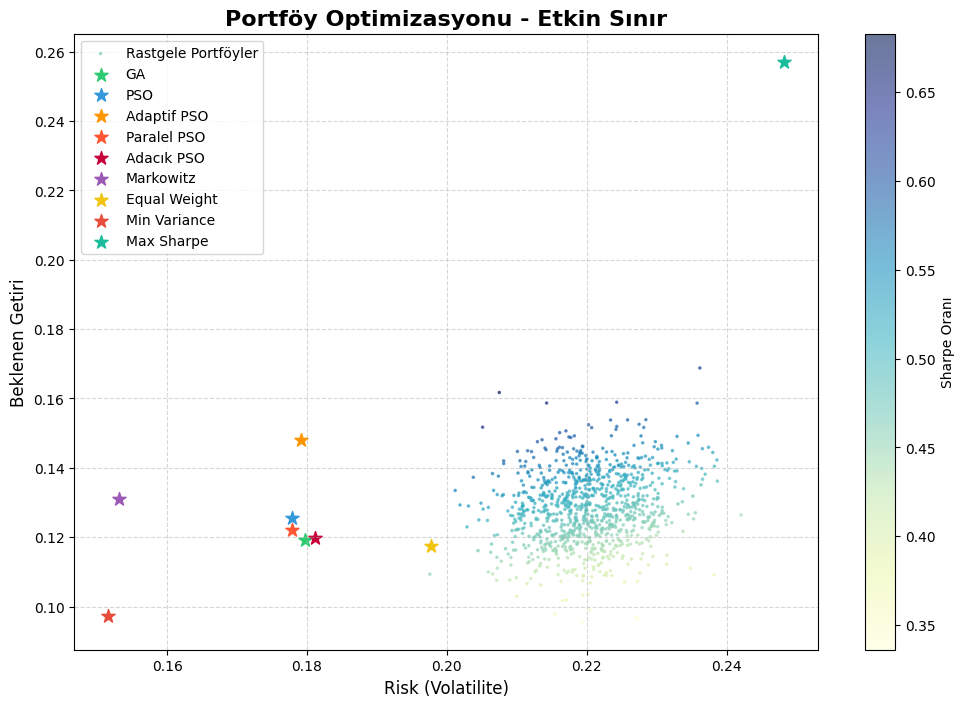

Portföy ağırlıkları grafiği oluşturuluyor...


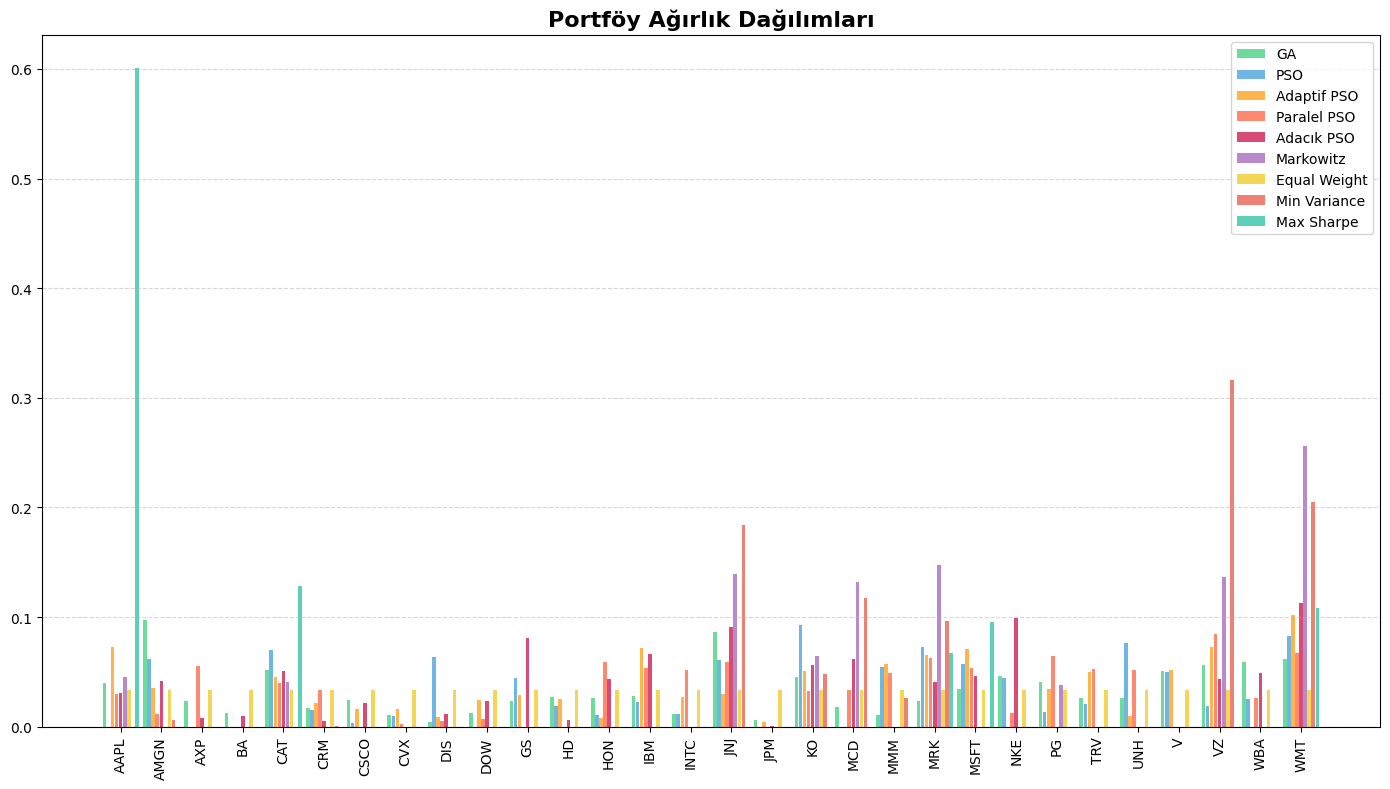

Train verisi performans metrikleri grafiği oluşturuluyor...


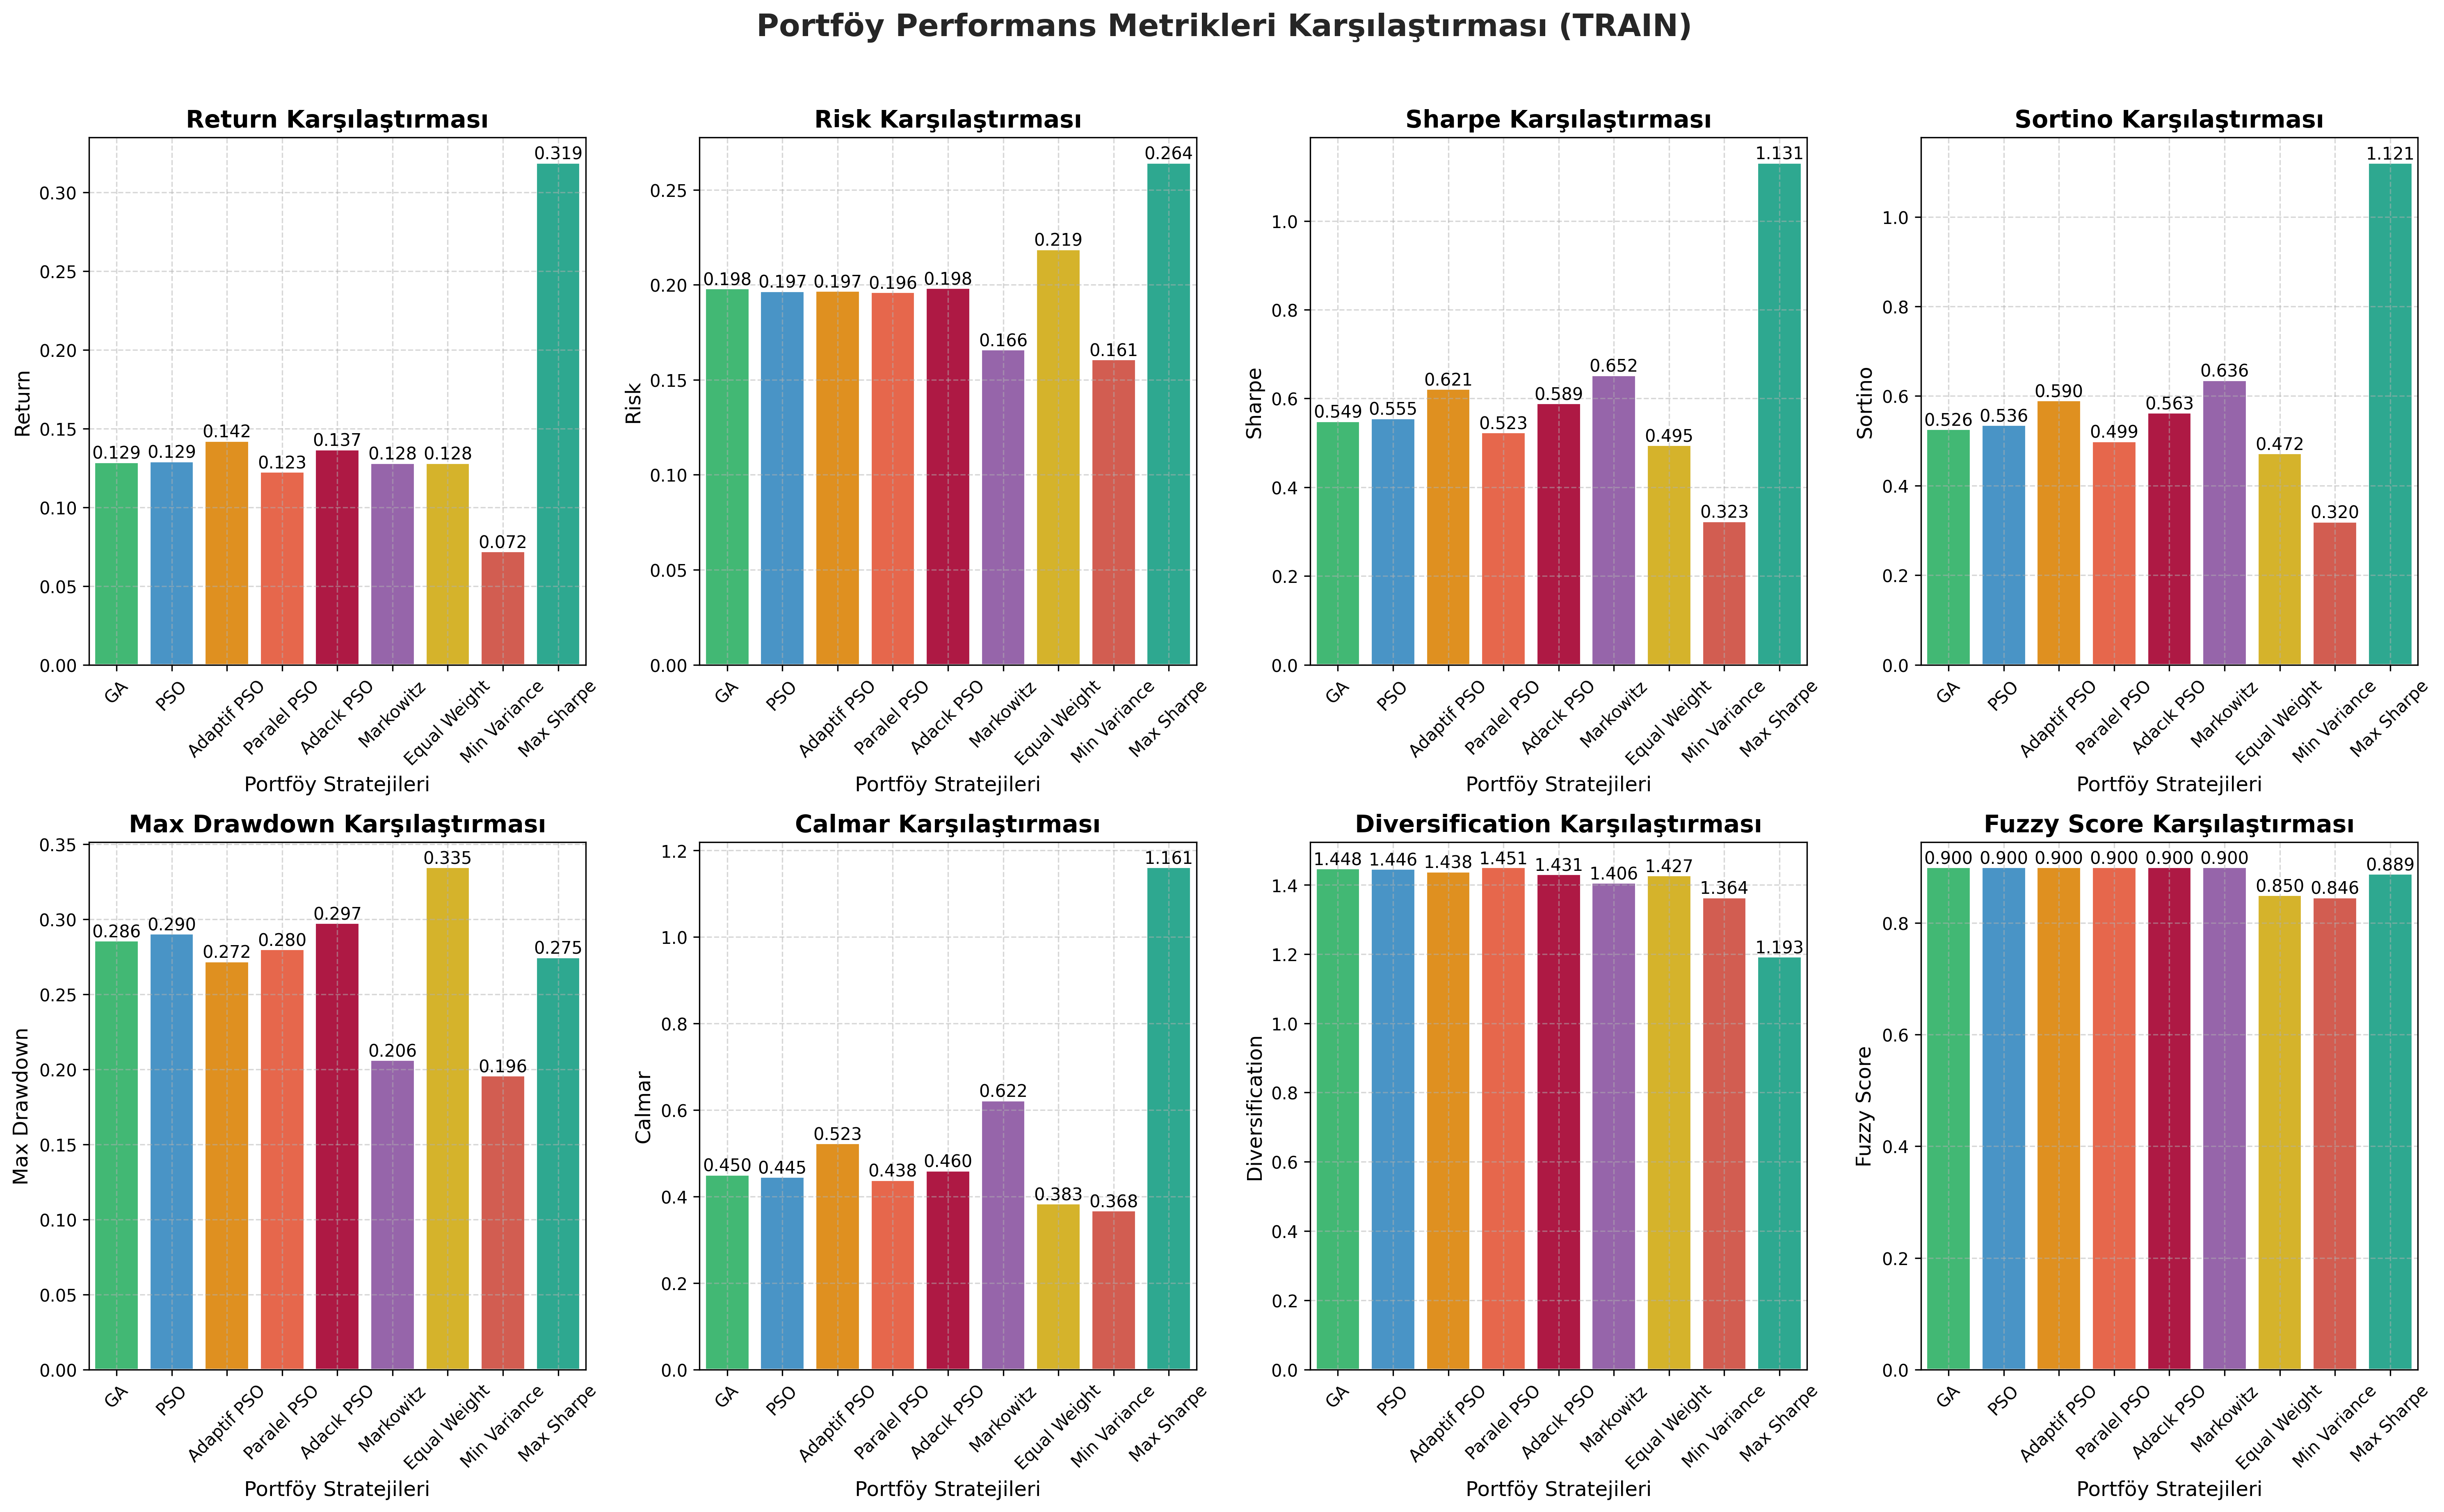

Test verisi performans metrikleri grafiği oluşturuluyor...


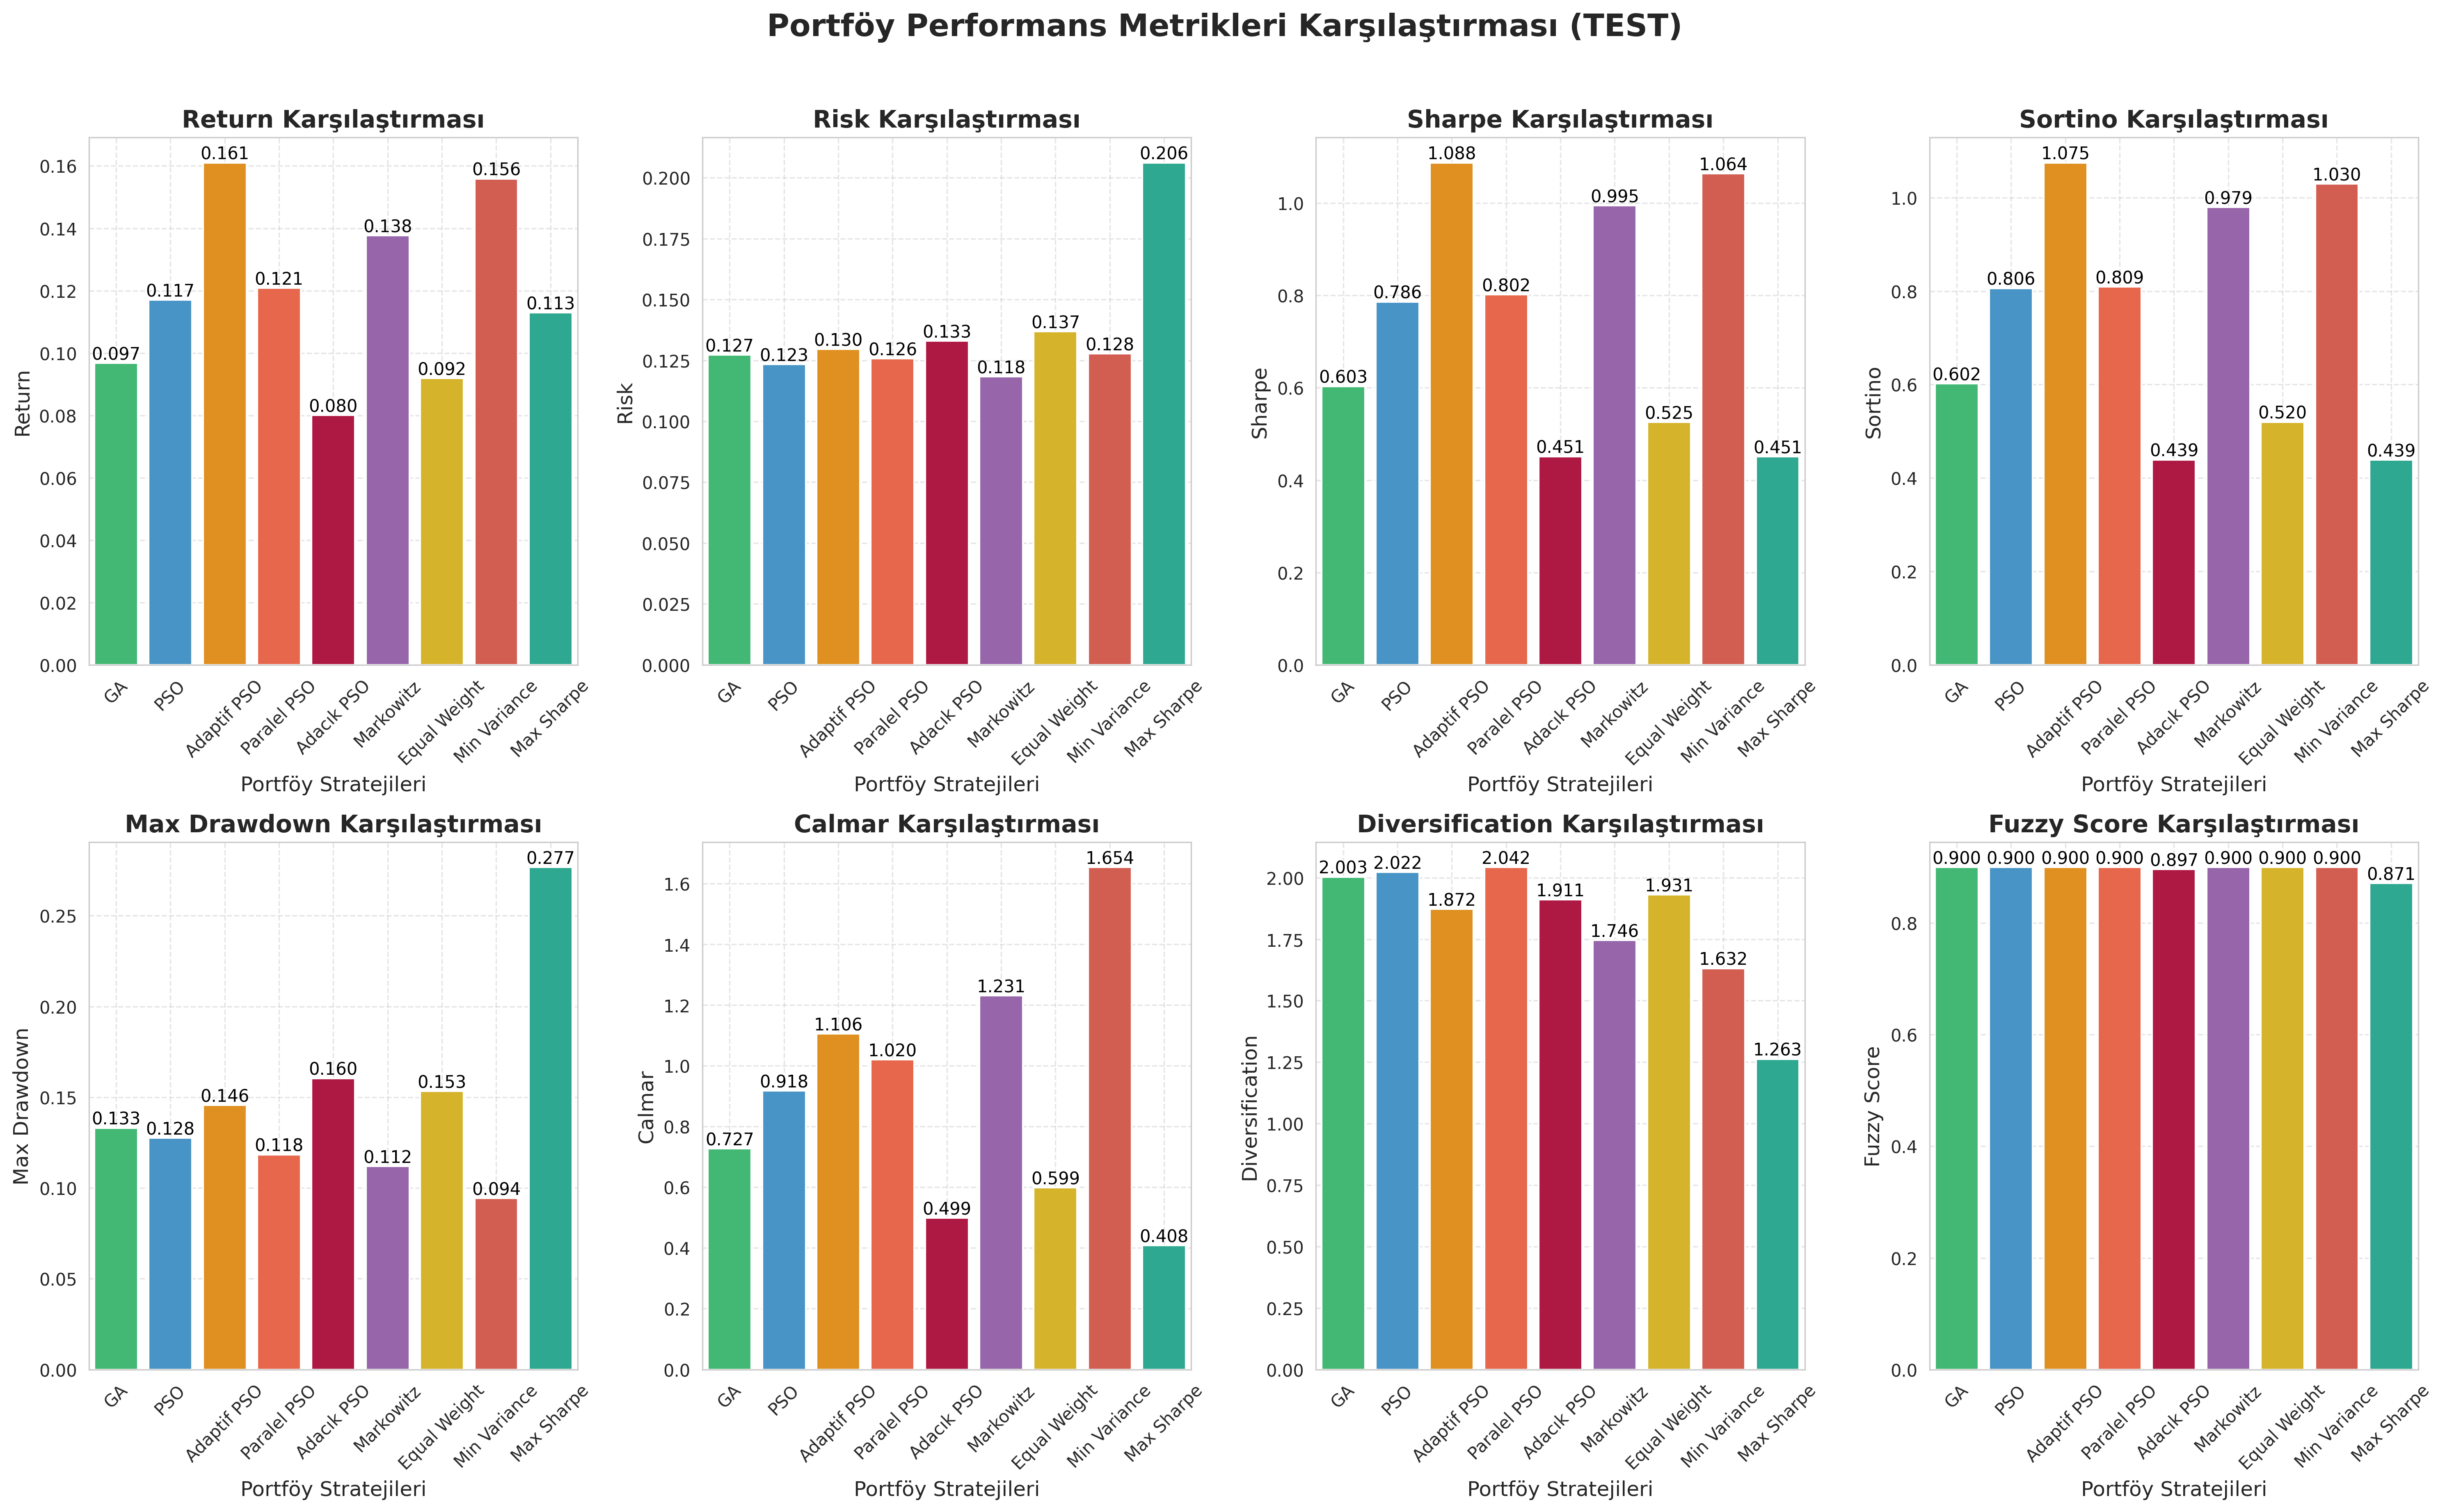

Backtest grafiği oluşturuluyor...


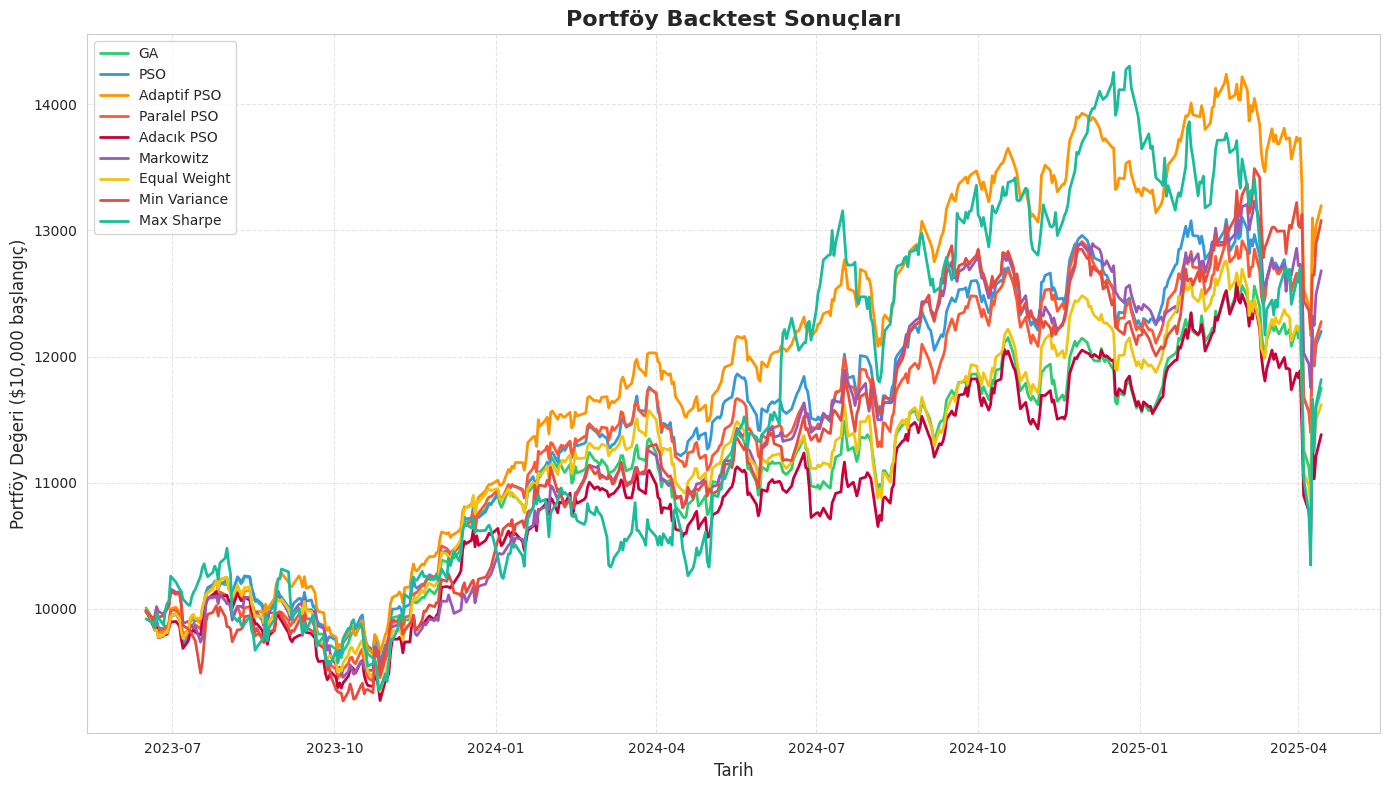

Drawdown grafiği oluşturuluyor...


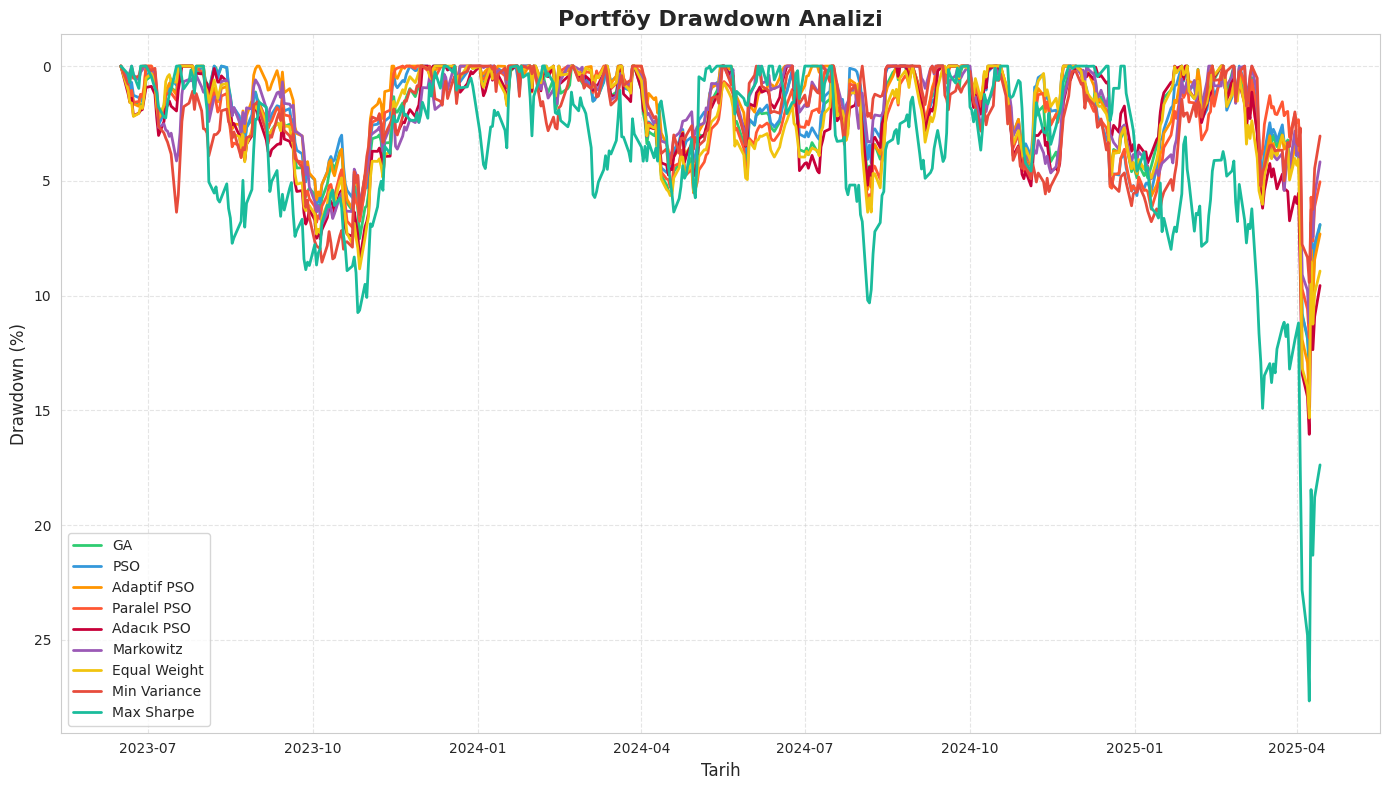

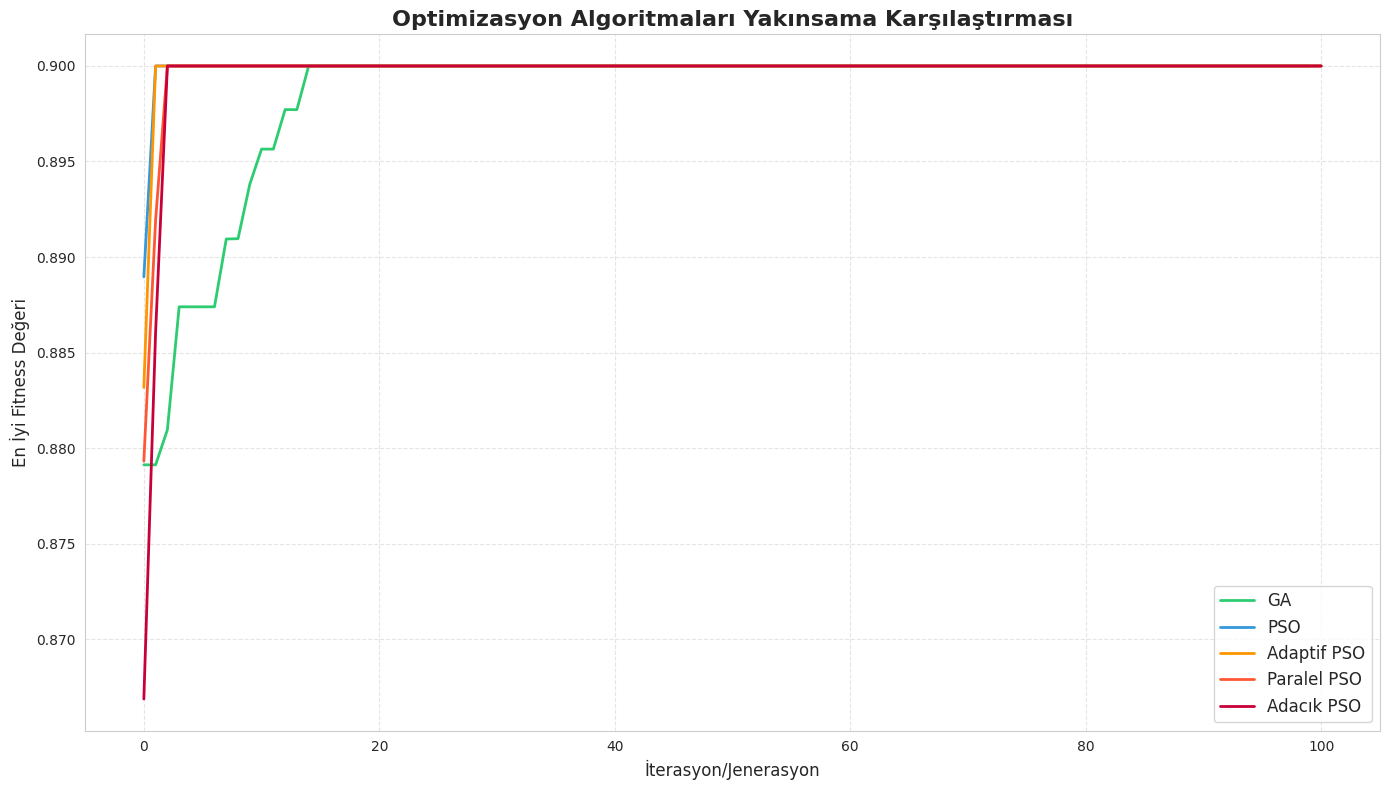

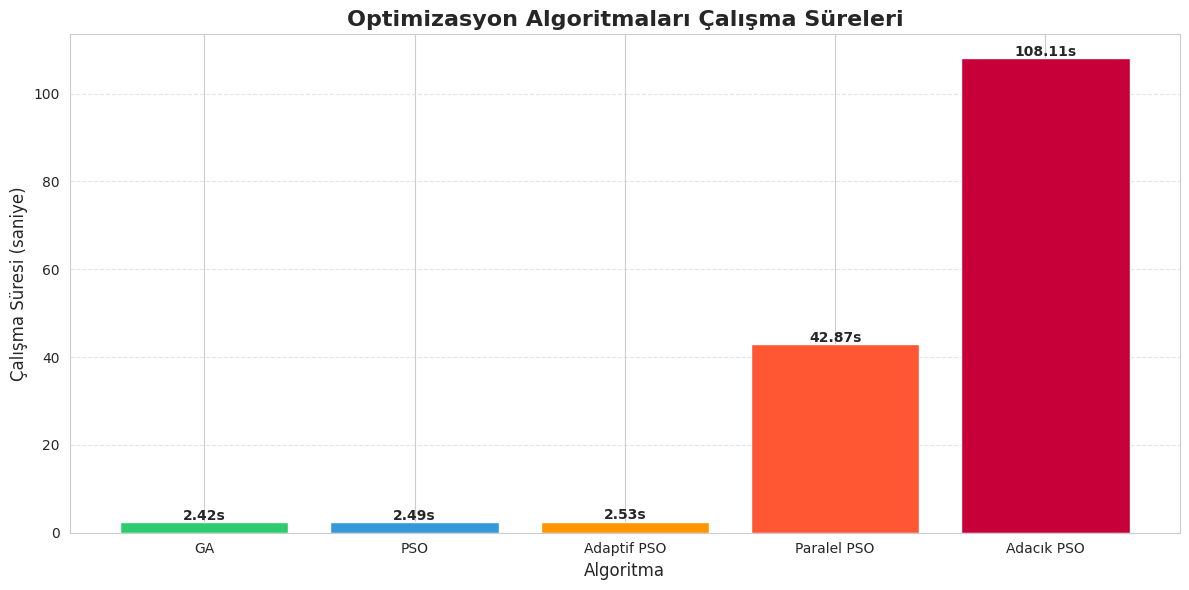


8. Test Performans Metrikleri Özeti:
                Return      Risk    Sharpe   Sortino  Max Drawdown    Calmar  \
Adaptif PSO   0.161038  0.129668  1.087682  1.074924      0.145641  1.105720   
Min Variance  0.155913  0.127760  1.063819  1.029552      0.094281  1.653716   
Markowitz     0.137711  0.118324  0.994819  0.979321      0.111892  1.230752   
Paralel PSO   0.120818  0.125760  0.801673  0.809249      0.118411  1.020327   
PSO           0.117030  0.123403  0.786289  0.806297      0.127552  0.917508   
GA            0.096759  0.127243  0.603247  0.602081      0.133084  0.727053   
Equal Weight  0.091898  0.136831  0.525452  0.519890      0.153370  0.599192   
Adacık PSO    0.080033  0.132987  0.451423  0.439175      0.160464  0.498762   
Max Sharpe    0.112923  0.206179  0.450689  0.438748      0.276654  0.408174   

              Diversification  Fuzzy Score  
Adaptif PSO          1.872099     0.900000  
Min Variance         1.631602     0.900000  
Markowitz            1.745

In [ ]:
# Bu bölümü en başta çalıştırarak gerekli tüm modülleri ve sınıfları içe aktarın
# Modülleri içe aktar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import warnings
import yfinance as yf
from scipy.optimize import minimize
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

# Uyarıları kapat
warnings.filterwarnings('ignore')

# Numba kontrolü
try:
    from numba import jit
    numba_available = True
    print("Numba kütüphanesi bulundu. Hızlandırılmış hesaplamalar kullanılacak.")
except ImportError:
    numba_available = False
    print("Numba kütüphanesi bulunamadı. Kod çalışacaktır, ancak daha yavaş olabilir.")

def main_function():
    """
    Tüm portföy optimizasyonu sürecini çalıştıran ana fonksiyon
    """
    print("=================================================")
    print("PSO ve GA Portföy Optimizasyonu Karşılaştırması")
    print("=================================================")

    # DJIA bileşenleri
    djia_tickers = [
        "AAPL", "AMGN", "AXP", "BA", "CAT", "CRM", "CSCO", "CVX", "DIS", "DOW",
        "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KO", "MCD", "MMM",
        "MRK", "MSFT", "NKE", "PG", "TRV", "UNH", "V", "VZ", "WBA", "WMT"
    ]

    # Veri sınıfını oluştur - train/test split ile
    portfolio_data = PortfolioData(djia_tickers, start_date='1990-01-01', end_date='2025-04-15', train_test_split=0.7)

    # Fuzzy mantık sistemini oluştur
    fuzzy_system = FuzzySystem(portfolio_data)

    # Optimizasyon sınıflarını oluştur
    ga_optimizer = PortfolioOptimizer(portfolio_data, fuzzy_system, risk_free=0.02)
    pso_optimizer = PSOOptimizer(portfolio_data, fuzzy_system, risk_free=0.02)
    adaptive_pso = AdaptivePSOOptimizer(portfolio_data, fuzzy_system, risk_free=0.02)
    parallel_pso = ParallelPSOOptimizer(portfolio_data, fuzzy_system, risk_free=0.02)

    # 1. GA Optimizasyonu
    print("\n1. GA Optimizasyonu Çalıştırılıyor...")
    start_time = time.time()
    ga_weights, ga_fitness, ga_history = ga_optimizer.optimize_ga(
        generations=100,
        pop_size=100,
        mutation_rate=0.1,
        crossover_rate=0.8,
        verbose=True
    )
    ga_time = time.time() - start_time
    print(f"GA Optimizasyonu tamamlandı. Süre: {ga_time:.2f} saniye")

    # 2. Standart PSO Optimizasyonu
    print("\n2. Standart PSO Optimizasyonu Çalıştırılıyor...")
    start_time = time.time()
    pso_weights, pso_fitness, pso_history = pso_optimizer.optimize_pso(
        iterations=100,
        n_particles=100,
        w=0.7,
        c1=1.5,
        c2=1.5,
        velocity_clamp=0.1,
        verbose=True
    )
    pso_time = time.time() - start_time
    print(f"PSO Optimizasyonu tamamlandı. Süre: {pso_time:.2f} saniye")

    # 3. Adaptif PSO Optimizasyonu
    print("\n3. Adaptif PSO Optimizasyonu Çalıştırılıyor...")
    start_time = time.time()
    adaptive_weights, adaptive_fitness, adaptive_history, parameter_history = adaptive_pso.optimize_adaptive_pso(
        iterations=100,
        n_particles=100,
        verbose=True
    )
    adaptive_time = time.time() - start_time
    print(f"Adaptif PSO Optimizasyonu tamamlandı. Süre: {adaptive_time:.2f} saniye")

    # 4. Paralel PSO Optimizasyonu
    print("\n4. Paralel PSO Optimizasyonu Çalıştırılıyor...")
    parallel_weights, parallel_fitness, parallel_history, parallel_time = parallel_pso.optimize_parallel_pso(
        iterations=100,
        n_particles=100,
        w=0.7,
        c1=1.5,
        c2=1.5,
        velocity_clamp=0.1,
        verbose=True
    )
    print(f"Paralel PSO Optimizasyonu tamamlandı. Süre: {parallel_time:.2f} saniye")

    # 5. Island Model PSO Optimizasyonu
    print("\n5. Adacık Modeli PSO Optimizasyonu Çalıştırılıyor...")
    island_weights, island_fitness, island_history, island_time = parallel_pso.optimize_island_model_pso(
        iterations=100,
        n_particles=100,
        n_islands=4,
        migration_interval=10,
        migration_rate=0.1,
        verbose=True
    )
    print(f"Adacık Modeli PSO Optimizasyonu tamamlandı. Süre: {island_time:.2f} saniye")

    # Benchmark stratejileri
    print("\n6. Benchmark Stratejileri Hesaplanıyor...")
    equal_weights = ga_optimizer.equal_weight()
    min_var_weights = ga_optimizer.min_variance()
    markowitz_weights = ga_optimizer.markowitz()
    max_sharpe_weights = ga_optimizer.max_sharpe()

    # Tüm portföyleri bir araya getir
    portfolios = {
        'GA': ga_weights,
        'PSO': pso_weights,
        'Adaptif PSO': adaptive_weights,
        'Paralel PSO': parallel_weights,
        'Adacık PSO': island_weights,
        'Markowitz': markowitz_weights,
        'Equal Weight': equal_weights,
        'Min Variance': min_var_weights,
        'Max Sharpe': max_sharpe_weights
    }

    # Görselleştirme sınıfını oluştur
    # Özel renkler ekle
    custom_colors = {
        'GA': '#2ecc71',             # Yeşil
        'PSO': '#3498db',            # Mavi
        'Adaptif PSO': '#FF9500',    # Turuncu
        'Paralel PSO': '#FF5733',    # Kırmızımsı turuncu
        'Adacık PSO': '#C70039',     # Koyu kırmızı
        'Markowitz': '#9b59b6',      # Mor
        'Equal Weight': '#f1c40f',   # Sarı
        'Min Variance': '#e74c3c',   # Kırmızı
        'Max Sharpe': '#1abc9c'      # Turkuaz
    }

    visualizer = PortfolioVisualizer(portfolio_data, ga_optimizer, portfolios)
    visualizer.colors.update(custom_colors)

    # Görselleştirme ve analiz
    print("\n7. Görselleştirme ve Analiz Yapılıyor...")

    # Etkin sınır grafiği
    print("Etkin sınır grafiği oluşturuluyor...")
    ef_plot = visualizer.plot_efficient_frontier(num_portfolios=1000)
    plt.savefig('efficient_frontier_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Portföy ağırlıkları grafiği
    print("Portföy ağırlıkları grafiği oluşturuluyor...")
    weights_plot = visualizer.plot_portfolio_weights()
    plt.savefig('portfolio_weights_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Performans metrikleri grafiği - Train verisi
    print("Train verisi performans metrikleri grafiği oluşturuluyor...")
    train_metrics_plot = visualizer.plot_performance_metrics(mode='train')
    plt.savefig('train_performance_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Performans metrikleri grafiği - Test verisi
    print("Test verisi performans metrikleri grafiği oluşturuluyor...")
    test_metrics_plot = visualizer.plot_performance_metrics(mode='test')
    plt.savefig('test_performance_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Backtest grafiği
    print("Backtest grafiği oluşturuluyor...")
    backtest_plot = visualizer.plot_backtest(initial_investment=10000)
    plt.savefig('backtest_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Drawdown grafiği
    print("Drawdown grafiği oluşturuluyor...")
    drawdown_plot = visualizer.plot_drawdown()
    plt.savefig('drawdown_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Yakınsama karşılaştırması grafiği
    plt.figure(figsize=(14, 8))

    # GA yakınsama grafiği
    ga_generations = [x[0] for x in ga_history]
    ga_fitness = [x[1] for x in ga_history]
    plt.plot(ga_generations, ga_fitness, label="GA", color=custom_colors['GA'], linewidth=2)

    # Standart PSO yakınsama grafiği
    pso_iterations = [x[0] for x in pso_history]
    pso_fitness = [x[1] for x in pso_history]
    plt.plot(pso_iterations, pso_fitness, label="PSO", color=custom_colors['PSO'], linewidth=2)

    # Adaptif PSO yakınsama grafiği
    adaptive_iterations = [x[0] for x in adaptive_history]
    adaptive_fitness = [x[1] for x in adaptive_history]
    plt.plot(adaptive_iterations, adaptive_fitness, label="Adaptif PSO", color=custom_colors['Adaptif PSO'], linewidth=2)

    # Paralel PSO yakınsama grafiği
    parallel_iterations = [x[0] for x in parallel_history]
    parallel_fitness = [x[1] for x in parallel_history]
    plt.plot(parallel_iterations, parallel_fitness, label="Paralel PSO", color=custom_colors['Paralel PSO'], linewidth=2)

    # Adacık PSO yakınsama grafiği
    island_iterations = [x[0] for x in island_history]
    island_fitness = [x[1] for x in island_history]
    plt.plot(island_iterations, island_fitness, label="Adacık PSO", color=custom_colors['Adacık PSO'], linewidth=2)

    plt.title("Optimizasyon Algoritmaları Yakınsama Karşılaştırması", fontsize=16, fontweight='bold')
    plt.xlabel("İterasyon/Jenerasyon", fontsize=12)
    plt.ylabel("En İyi Fitness Değeri", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='lower right', fontsize=12)

    plt.tight_layout()
    plt.savefig('convergence_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Çalışma süreleri karşılaştırması grafiği
    plt.figure(figsize=(12, 6))

    algorithm_names = ['GA', 'PSO', 'Adaptif PSO', 'Paralel PSO', 'Adacık PSO']
    execution_times = [ga_time, pso_time, adaptive_time, parallel_time, island_time]

    plt.bar(algorithm_names, execution_times, color=[custom_colors[name] for name in algorithm_names])
    plt.title('Optimizasyon Algoritmaları Çalışma Süreleri', fontsize=16, fontweight='bold')
    plt.xlabel('Algoritma', fontsize=12)
    plt.ylabel('Çalışma Süresi (saniye)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5, axis='y')

    # Değerleri çubukların üzerine ekle
    for i, val in enumerate(execution_times):
        plt.text(i, val + 0.5, f"{val:.2f}s", ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig('execution_times_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Test performans metrikleri tablosu
    print("\n8. Test Performans Metrikleri Özeti:")
    test_metrics = visualizer.calculate_all_metrics(mode='test')
    df_test_results = pd.DataFrame(test_metrics).T

    # Sharpe oranına göre sırala
    df_sorted = df_test_results.sort_values('Sharpe', ascending=False)
    print(df_sorted)

    # Hız iyileştirme oranları
    print("\n9. Hız İyileştirme Oranları:")
    print(f"- Standart PSO / GA: {ga_time/pso_time:.2f}x")
    print(f"- Adaptif PSO / GA: {ga_time/adaptive_time:.2f}x")
    print(f"- Paralel PSO / GA: {ga_time/parallel_time:.2f}x")
    print(f"- Adacık PSO / GA: {ga_time/island_time:.2f}x")
    print(f"- Paralel PSO / Standart PSO: {pso_time/parallel_time:.2f}x")
    print(f"- Adacık PSO / Standart PSO: {pso_time/island_time:.2f}x")

    # En iyi algoritma
    best_algo = df_sorted.index[0]
    print(f"\nEn yüksek Sharpe oranına sahip algoritma: {best_algo} (Sharpe: {df_sorted.loc[best_algo, 'Sharpe']:.4f})")

    # En hızlı algoritma
    times_dict = {
        'GA': ga_time,
        'PSO': pso_time,
        'Adaptif PSO': adaptive_time,
        'Paralel PSO': parallel_time,
        'Adacık PSO': island_time
    }
    fastest_algo = min(times_dict, key=times_dict.get)
    print(f"En hızlı çalışan algoritma: {fastest_algo} ({times_dict[fastest_algo]:.2f} saniye)")

    # Sonuç değerlendirmesi
    print("\n10. Sonuç Değerlendirmesi:")
    print("Bu karşılaştırmalı analiz, farklı optimizasyon algoritmalarının portföy optimizasyonundaki")
    print("performansını ve verimliliğini göstermektedir. Paralel PSO ve Adacık Modeli PSO,")
    print("geleneksel algoritmalara göre önemli hız avantajları sağlarken, Adaptif PSO")
    print("parametreleri otomatik ayarlayarak performansı artırmaktadır.")

    # Sonuç
    print("\nTüm grafikler ve analiz sonuçları başarıyla kaydedildi.")

    return {
        'portfolios': portfolios,
        'test_metrics': test_metrics,
        'execution_times': {
            'GA': ga_time,
            'PSO': pso_time,
            'Adaptif PSO': adaptive_time,
            'Paralel PSO': parallel_time,
            'Adacık PSO': island_time
        }
    }

# Ana programı çalıştır
if __name__ == "__main__":
    results = main_function()